# Estimacion mediante Procesos Gausianos (GP):

## Elementos basicos
En el presente documento se implementa una estimacion mediante un (GP). Recordemos que la forma basica de definir un GP esta dada por:
$$
f(x) \sim \mathcal{G}\mathcal{P}(\text{m}(x), \text{K}(x,x'))
$$
donde:
* $f$ es la funcion que se quiere modelar.
* $\text{m}$ es la funcion de media.
* $\text{K}$ es la funcion de covarianza, tambien llamada kernel.

En esencia, <span style="color:red">el modelo GP queda definido por su **_kernel_** </span> . Este define como se correlacionan los datos, ademas de dar ciertas caracteristicas a la funcion que resultara del modelo. Existen muchos tipos de kernels, cada uno con propiedades muy diferentes. Por ejemplo, uno de los kernels mas usados es **RBF** (Radial Basis Function):
$$
\text{K}(x,x') = \sigma^2 \exp \left[- \dfrac{\|x-x'\|^2}{2 \ell^2}\right]
$$
donde:

* $\ell$ es el _lengthscale_. Este parametro define la "ventana" en la que ocurre una variacion de la data.

* $\sigma^2$ es la varianza (amplitud) del kernel. 

Por ejemplo, uno puede utilizar este kernel para representar osilaciones locales de la funcion $f$ que se quiere modelar.

<br>
<br>

## Base de Datos
Para el ejercicio de estimacion, se considera una base compuesta por $N = 21.781$ datos, los cuales tiene como caracteristicas `midx`, `midy`, `midz` y `au` (donde `au` viene del oro). Asi, la matriz $X$ que codificara los datos de entrada sera de dimensiones $N \times 3$ (notar que la cantidad de columnas esta dada por los _features_ de nuestro problema, i.e. `midx`,`midy`,`midz`) y la variable a estimar, $y$, sera el oro `au`.
<br>
<br>

## Entrenamiento y Evaluacion

Para poder entrenar y evaluar el modelo, se realizara validacion cruzada con el conjunto de datos. Mas especificamente, por cada sondaje (identificado por su `dhid`) se utilizara como conjunto de entrenamiento un subconjunto de muestras de los demas sondajes con $\texttt{dhid}$ en $\texttt{DHID}\setminus{\{\texttt{dhid}\}}$, con $\texttt{DHID}$ el conjunto de $\texttt{DHID}$ de todos los sondajes. Aqui se presentan dos opciones por lo menos para entrenar: Para fijar ideas, sea $\texttt{dhid}_{\text{TEST}}$ el sondaje a estimar:

1. Por cada punto $x^*$ en $\texttt{dhid}_{\text{TEST}}$, definir una bola de radio `distancia` y centro $x^*$, para 
y considerar para el entrenamiento las muestras que se encuentren dentro de dicha bola. La evaluacion se realiza por cada punto de $\texttt{dhid}_1$.
2. Para todos los puntos de $\texttt{dhid}_{\text{TEST}}$, considerar el mismo conjunto de entrenamiento. Este consistira en la union de todas las muestras que se obtienen al considerar una bola de centro un punto de $\texttt{dhid}_{\text{TEST}}$ y radio `distancia`. Luego se evalua en todos los puntos de $\texttt{dhid}_{\text{TEST}}$.
<br>
<br>
#### <span style="color:red"> *observacion* </span>: Es importante notar que la segunda forma solo entrena una vez, mientras que la primera entrena por cada punto del sondaje a estimar.

## Eleccion del modelo

Para este ejercicio, la eleccion del modelo se centrara esencialmente en la eleccion del kernel. Para abordar este problema, se procedera a una busquead automatizada del kernel, la cual se baso en [este maravilloso paper][kernelSearch].





### Esquema de busqueda
Para la busqueda, se consideraran $n$ kernels base:
* RBF:
$$
\text{K}(x,x') = \sigma^2 \exp \left[- \dfrac{\|x-x'\|^2}{2 \ell^2}\right]
$$
* Matern32:
$$
k(x,x') = \sigma^2\left( 1+ \dfrac{\sqrt{3\|x-x'\|^2}}{\ell} \right) \exp \left[ -\dfrac{\sqrt{3\|x-x'\|^2}}{\ell}\right]
$$
* Matern52:
$$
k(x,x') = \sigma^2 \left( 1 + \dfrac{\sqrt{5\|x-x'\|^2}}{\ell} + \dfrac{5\|x-x'\|^2}{3 \ell^2}\right) \exp \left[ -\dfrac{\sqrt{5\|x-x'\|^2}}{\ell} \right] 
$$
* 

[kernelSearch]:https://arxiv.org/pdf/1302.4922.pdf

Some Markdown text with <span style="color:blue">some *blue* text</span>.

In [1]:
import GPy
import numpy as np
import time
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.spatial as spatial
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C,RationalQuadratic,ExpSineSquared,DotProduct,Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from jupyterthemes import jtplot

In [9]:
# se cargan los datos de entrenamiento
train_data = pd.read_csv('../GP_Data/cy17_spc_assays_rl6_entry.csv')
test_data_pozo = pd.read_csv('../GP_Data/cy17_spc_assays_pvo_entry_ug.csv')
# se definen los estilos de los graficos
jtplot.style(theme='onedork',figsize = (16.5,12))

In [ ]:
X_head = train_data.head()

In [62]:
tests_ug = sacar_repeticiones(test_data_pozo['ugcut'])
train_ug = sacar_repeticiones(train_data['ugcut'])
sorted(train_ug)

[-99.0, 10.0, 20.0, 30.0, 40.0, 50.0, 51.0, 60.0, 61.0, 70.0, 71.0, 80.0]

In [63]:
sorted(tests_ug)

[-99, 0, 10, 20, 30, 40, 50, 51, 60, 61, 70, 71, 80]

In [28]:
print(test_data_pozo.loc[test_data_pozo['ugcut']>=10].shape[0])
print(train_data.loc[train_data['ugcut']>=10].shape[0])

96511
88704


In [48]:
df = pd.DataFrame({
    'col_1': [0, 1, 2, 3],
    'col_2': [4, 5, 6, 7]
})
df.as_matrix().shape[0]

4

In [58]:
df_new = pd.concat(
    [
        df,
        pd.DataFrame(
            [[np.nan, 'dogs', 3]], 
            index=df.index, 
            columns=['column_new_1', 'column_new_2', 'column_new_3']
        )
    ], axis=1
)
df_matrix = df_new.as_matrix()
df_matrix[:,0:]
for i,fila in enumerate(df_matrix):
    print(fila)

[0 4 nan 'dogs' 3]
[1 5 nan 'dogs' 3]
[2 6 nan 'dogs' 3]
[3 7 nan 'dogs' 3]


In [69]:
test_point_zeros = np.zeros(shape=(1, 14))
test_point_std =[3, 3, 3] 
test_point_zeros[0, :3] = test_point_std[:3]
test_point_zeros

array([[3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [73]:
np.array([test_point_std])
np.array([[test_point_std[0],test_point_std[1],test_point_std[2]]])

array([[3, 3, 3]])

In [57]:
df_matrix[:,:1] = np.ones(shape=(df_matrix.shape[0], 1))
df_matrix

array([[1.0, 4, nan, 'dogs', 3],
       [1.0, 5, nan, 'dogs', 3],
       [1.0, 6, nan, 'dogs', 3],
       [1.0, 7, nan, 'dogs', 3]], dtype=object)

In [12]:
def sacar_repeticiones(iterable):
    seen = set()
    lista_sin_rep = []
    for item in iterable:
        if item not in seen:
            seen.add(item)
            lista_sin_rep.append(item)
    return lista_sin_rep


def get_data_dhid_test_point(dhid, test_point, distancia, train_data):
    # Esta funcion retorna una tupla X,y
    # de modo que X no contiene puntos del
    # sondaje de id dhid, y adem'as retorna
    # solo los X dentro de una esfera de radio
    # distancia entorno a test_point

    # X_dhid = train_data.loc[train_data['dhid']==dhid][['midx','midy','midz']].as_matrix()
    dhid_bool = train_data['dhid'] != dhid
    train_data_dhid = train_data[dhid_bool]
    X_train = train_data_dhid[['midx','midy','midz']].as_matrix()
    y = train_data_dhid[['au']].as_matrix()
    #X_train = train_data.loc[train_data['dhid'] != dhid][['midx', 'midy', 'midz']].as_matrix()
    #y = train_data.loc[train_data['dhid'] != dhid]['au'].as_matrix()
    
    # tree_X_dhid = spatial.cKDTree(X_dhid)
    tree_test = spatial.cKDTree(X_train)
    # pairsList = tree_X_dhid.query_ball_tree(tree_test,distancia)
    idx = tree_test.query_ball_point(list(test_point), distancia)  # como se hace para
    # un punto no se repiten
    # idx = list(set(x for l in pairsList for x in l)) # indices de los puntos test
    # que se encuentran a <= distancia
    
    trainable =False
    if len(idx) >= 20:
        trainable == True
    return X_train[idx, :], y[idx], trainable

def get_df_dhid_test_point(dhid, test_point, distancia, train_data):
    # Esta funcion retorna una tupla X,y
    # de modo que X no contiene puntos del
    # sondaje de id dhid, y adem'as retorna
    # solo los X dentro de una esfera de radio
    # distancia entorno a test_point
    
    dhid_bool = train_data['dhid'] != dhid
    train_data_dhid = train_data[dhid_bool]
    X_train_dhid = train_data_dhid[['dhid','midx','midy','midz']]
    X_train = train_data_dhid[['midx','midy','midz']].as_matrix()
    y = train_data_dhid[['au']].as_matrix()
    
    train_tree = spatial.cKDTree(X_train)
    
    idx = train_tree.query_ball_point(list(test_point), distancia)  # como se hace para
    
    trainable =False
    if X_train_dhid.iloc[idx,:].shape[0] >= 20:
        trainable = True
    return X_train_dhid.iloc[idx,:], y[idx], trainable

def get_dhids():
    df = pd.read_csv('../../GP_Data/cy17_spc_au_rl6_entry.csv')
    df_dhid = df['dhid']
    seen = set()
    DHID = []
    for item in df_dhid:
        if item not in seen:
            seen.add(item)
            DHID.append(item)
    return DHID

def get_au_xyz_by_dhid(dhid):
    train_data = pd.read_csv('../../GP_Data/cy17_spc_au_rl6_entry.csv')
    xyz_au = train_data.loc[train_data['dhid'] == dhid][['midx','midy','midz','au']].as_matrix()
    return xyz_au

In [4]:
def main_jupyter(modelo,ker,Plotear = False):
    # se cargan los sondajes y se obtienen los dhid
    train_data = pd.read_csv('../../GP_Data/cy17_spc_au_rl6_entry.csv')
    DHIDs = get_dhids()

    # se cargan los datos de prueba
    test_data = pd.read_csv('../../GP_Data/ok_au.csv')
    data_matrix = test_data[['xcentre', 'ycentre', 'zcentre', 'au']].as_matrix()
    data_matrix = data_matrix[data_matrix[:, 3] > 0]  # notar que donde no se estimo se ingresa -99
    X_test = data_matrix[:, :3]

    # se setea el path para guardar predicciones
    path_csv = 'C:\\Users\\jpdon\\Desktop\\BHP2018\\GP_nb\\GP_Data\\'
    nombre = 'gp_au'

    # se define el objeto dataFrame que almacenara las predicciones
    cols_names = ['dhid', 'midx', 'midy', 'midz', 'au_gp', 'sigma']
    df = pd.DataFrame(columns=cols_names)
    df_pred_med = pd.DataFrame(columns = ['y_pred','y_med','trained'])

    # se define la distancia a la cual se buscan los sondajes para entrenar
    distancia = 50

    y_preds_tot = list()
    y_meds_tot = list()
    train_dicc = dict()
    dicc_preds = dict() # se gurdan las estimaciones hechas por id
    #for dhid in DHIDs[100:104]:
    for dhid in ['SPD1647']:
        print('Se ajusta el modelo para id: {}\n'.format(dhid))

        y_preds = list()
        y_medido = list()

        X_dhid = train_data.loc[train_data['dhid'] == dhid][['midx', 'midy', 'midz']].as_matrix()
        y_medido_matrix = train_data.loc[train_data['dhid'] == dhid][['au']].as_matrix()
        y_medido.extend(list(y_medido_matrix))
        print('Puntos a estimar:{}'.format(X_dhid.shape[0]))
        print('\n')
        for test_point in X_dhid:
            # se obtienen los datos de entrenamiento
            X, y, trainable = get_data_dhid_test_point(dhid, test_point, distancia, train_data)
            
            #X_std = (X - X.mean()) / X.std()
            #y_std = (y - y.mean()) / y.std()
            
            # inicializacion  del modelo
            
            #m = GPy.models.GPRegression(X,y,kernel=ker,) # lo utilizo para usar el kernel con periodo
            if modelo == 'sgpr':
                m = GPy.models.SparseGPRegression(X, y, ker) #pol, per not implemented
            elif modelo == 'gpr':
                m = GPy.models.GPRegression(X,y,kernel=ker)
            
            try:
                #print('Datos de entrenamiento: {}'.format(X.shape[0]))
                m.optimize(messages=False,max_f_eval = 1000)
                #test_point_std = (test_point - X_dhid.mean()) / X_dhid.std()
                y_pred, sigma = m.predict(np.array([[test_point[0],
                                                     test_point[1],test_point[2]]]))
                y_preds.extend(list(y_pred))
                #y_preds.extend(list(y_pred*y.std()+y.mean()))
            except np.linalg.LinAlgError:
                print('La matriz definida por el kernel no es definida positiva')
                y_pred = 0
                sigma = 0
                y_preds.extend(list([0]))
                pass
            except GPy.util.linalg.LinAlgError:
                print('La matriz no es definida positiva, incluso con jitter')
                pass
            fila = []
            fila.extend([dhid])
            fila.extend(list(test_point))
            fila.extend([y_pred, sigma])

            df = df.append(pd.DataFrame([fila], columns=cols_names))

        print('Entrenamiento para sondaje {} terminado'.format(dhid))
        y_preds = np.array(y_preds)
        dicc_preds[dhid] = y_preds # guardamos las estimaciones por dhid
        y_medido = np.array(y_medido)
        
        # se analizan los resultados por dhid
        fig, ax = plt.subplots()
        ax.scatter(y_medido, y_preds, edgecolors=(0, 0, 0))
        ax.plot([y_medido.min(), y_medido.max()], [y_medido.min(), y_medido.max()], 'k--', lw=2)
        ax.set_xlabel('Medido')
        ax.set_ylabel('Prediccion')
        ax.set_title('Regresion para el sondaje %s' % dhid)
       # ax.set_title('DHID:%s, Kernel: %s' % (dhid,gp.kernel_))
        print('')
        print('#############################################################')
        print('')
    
    if Plotear:
        plt.show()
    
    # se guardan las predicciones en path_csv+nombre
    df.to_csv(path_csv + nombre + '.csv', sep=',')
    return y_preds, y_medido, dicc_preds

In [112]:
def suma_rbf(n,dim_activa):
    kernel_list = list()
    for i in range(n):
        kernel_rbf = GPy.kern.RBF(input_dim = 1,active_dims = [dim_activa])
        kernel_list.append(kernel_rbf)
    return GPy.kern.Add(kernel_list)

def suma_Matern32(n,dim_activa):
    kernel_list = list()
    for i in range(n):
        kernel_mat32 = GPy.kern.Matern32(input_dim = 1,active_dims = [dim_activa])
        kernel_list.append(kernel_mat32)
    return GPy.kern.Add(kernel_list)

def suma_Mat32_ARD(n):
    kernel_list = list()
    for i in range(n):
        k = GPy.kern.Matern32(3, ARD = True)
        kernel_list.append(k)
    return GPy.kern.Add(kernel_list)

 # Kernel: $\text{Mat}32(z)$

  Mat32.       |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    1.0  |      +ve      |        

Se ajusta el modelo para id: SPD1647

Puntos a estimar:82




 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\core\gp.py:87: UserWarning:Your kernel has a different input dimension 1 then the given X dimension 3. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel
 C:\Users\jpdon\Anaconda3\lib\site-packages\paramz-0.8.7-py3.6.egg\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:331: RuntimeWarning:invalid value encountered in true_divide
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:167: RuntimeWarning:overflow encountered in true_divide
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:430: RuntimeWarning:invalid value encountered in multiply


Entrenamiento para sondaje SPD1647 terminado

#############################################################



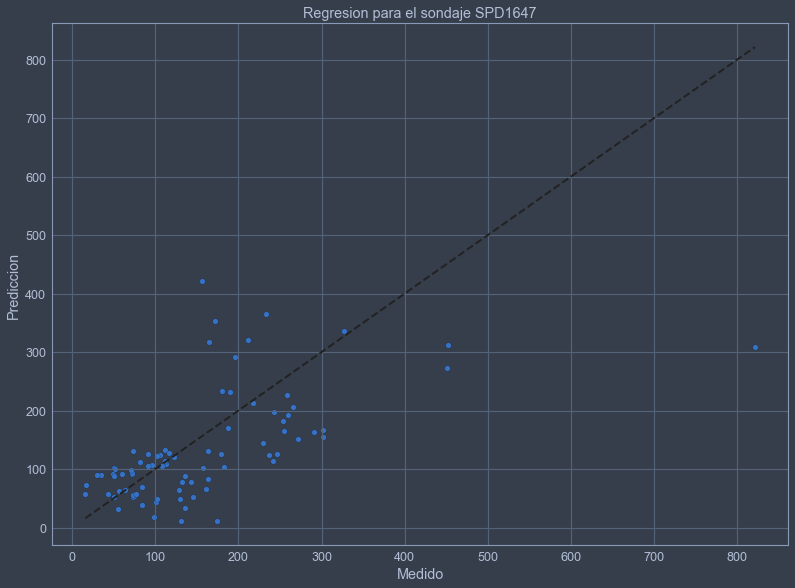


Parametros del kernel despues del entrenamiento

  Mat32.       |          value  |  constraints  |  priors
  variance     |  161782.050943  |      +ve      |        
  lengthscale  |  20480.6724972  |      +ve      |        


In [9]:
# kernel: Matern32
ker = GPy.kern.Matern32(input_dim=1, active_dims=[2])
print(ker)
print('')
_,_, dicc_preds_mat32Z = main_jupyter('sgpr',ker,Plotear = True)
print('')
print('Parametros del kernel despues del entrenamiento\n')
print(ker)

 # Kernel: $\text{Mat}32(x,y,z)$

  Mat32.       |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    1.0  |      +ve      |        

Se ajusta el modelo para id: SPD1647

Puntos a estimar:82




 C:\Users\jpdon\Anaconda3\lib\site-packages\paramz-0.8.7-py3.6.egg\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:167: RuntimeWarning:overflow encountered in true_divide
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:430: RuntimeWarning:invalid value encountered in multiply


Entrenamiento para sondaje SPD1647 terminado

#############################################################



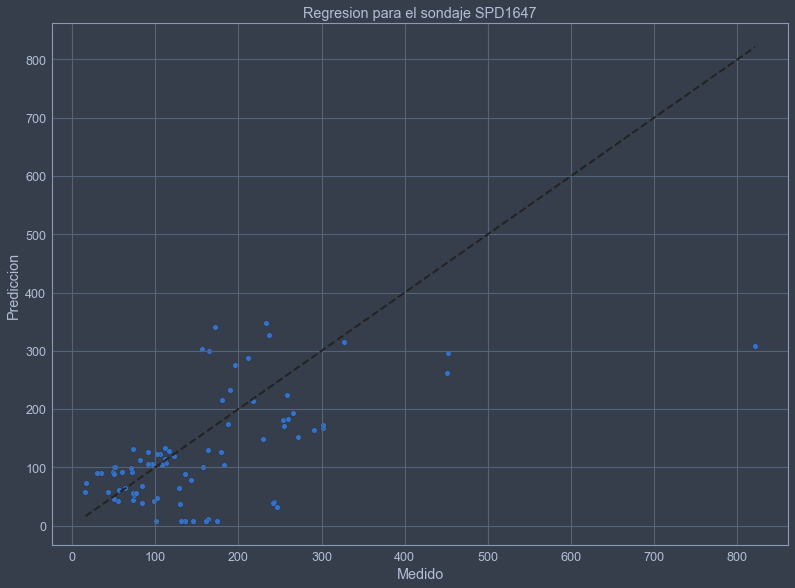


Parametros del kernel despues del entrenamiento

  Mat32.       |          value  |  constraints  |  priors
  variance     |  111393.998199  |      +ve      |        
  lengthscale  |  76208.5398978  |      +ve      |        


In [57]:
# kernel: Matern32
ker = GPy.kern.Matern32(3)
print(ker)
print('')
_,_, dicc_preds_mat32 = main_jupyter('sgpr',ker,Plotear = True)
print('')
print('Parametros del kernel despues del entrenamiento\n')
print(ker)

# Kernel: $\text{Mat}32\text{ARD}(x,y,z)$

  Mat32.       |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |   (3,)  |      +ve      |        

Se ajusta el modelo para id: SPD1647

Puntos a estimar:82




 C:\Users\jpdon\Anaconda3\lib\site-packages\paramz-0.8.7-py3.6.egg\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:invalid value encountered in add
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:236: RuntimeWarning:invalid value encountered in true_divide
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:430: RuntimeWarning:invalid value encountered in multiply
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:136: RuntimeWarning:overflow encountered in square


Entrenamiento para sondaje SPD1647 terminado

#############################################################



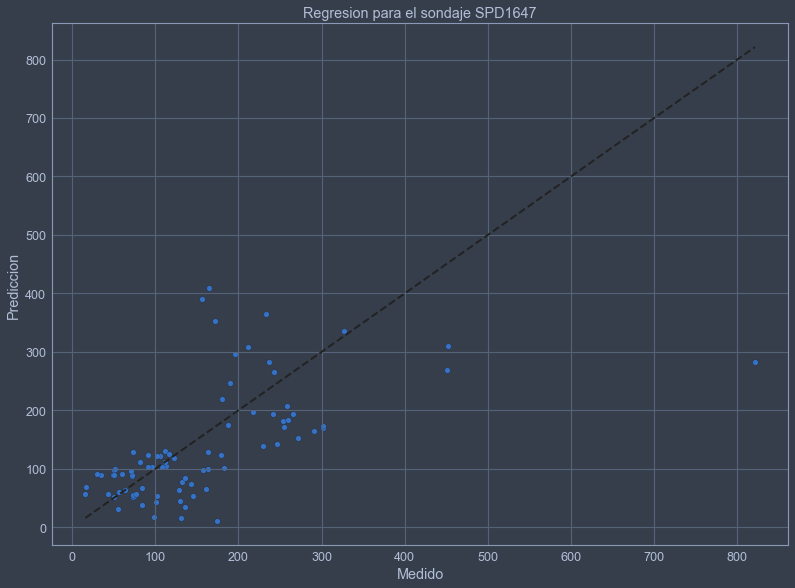


Parametros del kernel despues del entrenamiento

  Mat32.       |          value  |  constraints  |  priors
  variance     |  7887.44828336  |      +ve      |        
  lengthscale  |           (3,)  |      +ve      |        
LengthScales de Mat52Ard
  index  |  sparse_gp.Mat32.lengthscale  |  constraints  |  priors
  [0]    |               15695.33279675  |      +ve      |        
  [1]    |                7797.08039039  |      +ve      |        
  [2]    |             6845292.80863626  |      +ve      |        


In [87]:
# kernel: Matern32(ard =True)
ker = GPy.kern.Matern32(3,ARD= True)
print(ker)
print('')
y_preds, y_medido, dicc_preds_mat32ARD = main_jupyter('sgpr',ker,Plotear = True)
print('')
print('Parametros del kernel despues del entrenamiento\n')
print(ker)
print('LengthScales de Mat52Ard')
print(ker.lengthscale)

# Kernel: $\cos(z)\text{Mat}32(x,y,z)$


  mul.                |  value  |  constraints  |  priors
  Mat32.variance      |    1.0  |      +ve      |        
  Mat32.lengthscale   |    1.0  |      +ve      |        
  Cosine.variance     |    1.0  |      +ve      |        
  Cosine.lengthscale  |   10.0  |      +ve      |        

Se ajusta el modelo para id: SPD1647

Puntos a estimar:82




 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:167: RuntimeWarning:overflow encountered in true_divide
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:594: RuntimeWarning:invalid value encountered in cos
 C:\Users\jpdon\Anaconda3\lib\site-packages\paramz-0.8.7-py3.6.egg\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:430: RuntimeWarning:invalid value encountered in multiply
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:331: RuntimeWarning:invalid value encountered in true_divide


Entrenamiento para sondaje SPD1647 terminado

#############################################################



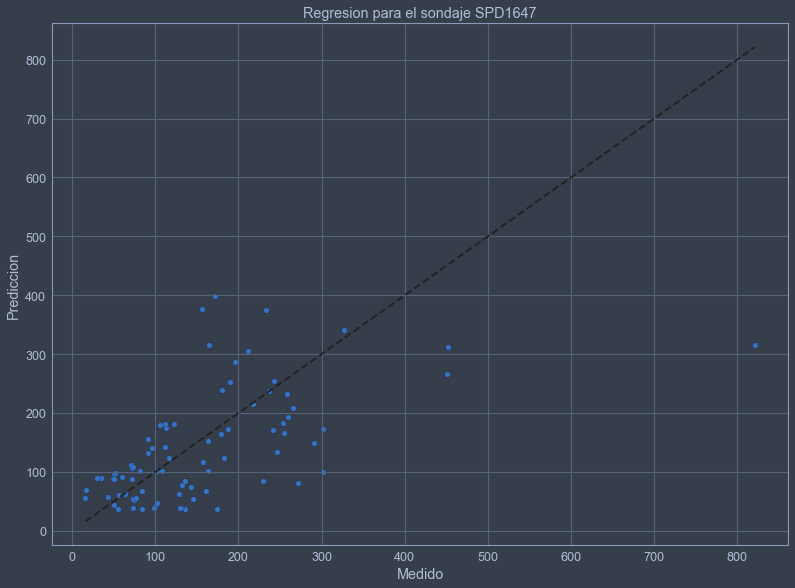


Parametros del kernel despues del entrenamiento

  mul.                |          value  |  constraints  |  priors
  Mat32.variance      |   1819.4866969  |      +ve      |        
  Mat32.lengthscale   |  3921502.07618  |      +ve      |        
  Cosine.variance     |  4.33715311494  |      +ve      |        
  Cosine.lengthscale  |  9777.80440029  |      +ve      |        


In [14]:
#ker = cos(z)*mat32
mat32 = GPy.kern.Matern32(3)
cos = GPy.kern.Cosine(input_dim=1,active_dims=[2])
cos.lengthscale = 10
ker = mat32*cos # este kernel, con los parametros libre mejor un poquito el modelo
print(ker)
print('')
y_preds, y_medido, dicc_preds_mat32CosZ = main_jupyter('sgpr',ker,Plotear = True)
print('')
print('Parametros del kernel despues del entrenamiento\n')
print(ker)

# Kernel: $\cos(z) \text{Mat}32\text{ARD}(x,y,z)$

  mul.                |  value  |  constraints  |  priors
  Mat32.variance      |    1.0  |      +ve      |        
  Mat32.lengthscale   |   (3,)  |      +ve      |        
  Cosine.variance     |    1.0  |      +ve      |        
  Cosine.lengthscale  |   10.0  |      +ve      |        

Se ajusta el modelo para id: SPD1647

Puntos a estimar:82




 C:\Users\jpdon\Anaconda3\lib\site-packages\paramz-0.8.7-py3.6.egg\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:136: RuntimeWarning:overflow encountered in square
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:invalid value encountered in add
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:331: RuntimeWarning:invalid value encountered in true_divide
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:167: RuntimeWarning:overflow encountered in true_divide
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:594: RuntimeWarning:invalid value encountered in cos
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:236: RuntimeWarning:invalid va

Entrenamiento para sondaje SPD1647 terminado

#############################################################



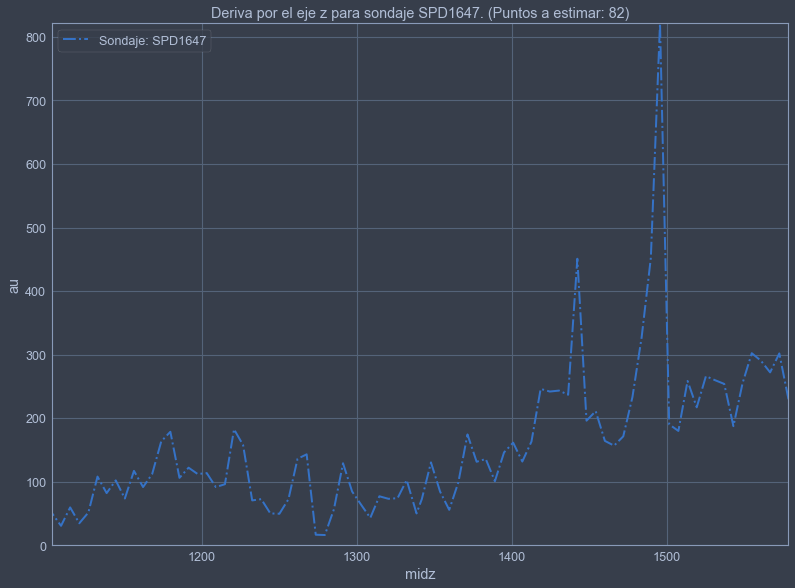

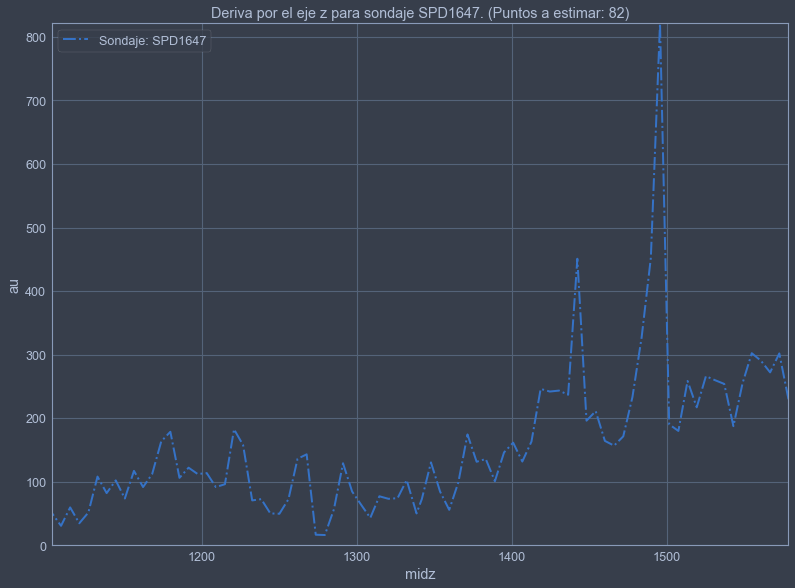

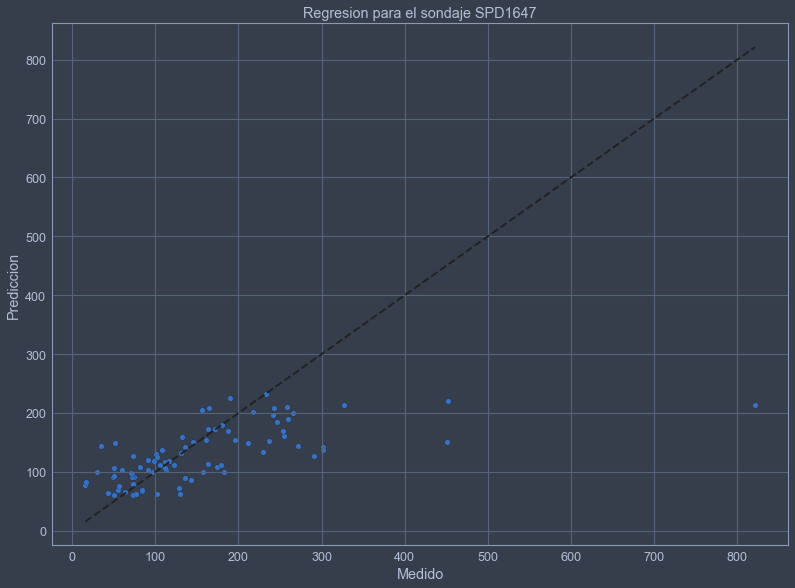


Parametros del kernel despues del entrenamiento

  mul.                |          value  |  constraints  |  priors
  Mat32.variance      |  577.335777308  |      +ve      |        
  Mat32.lengthscale   |           (3,)  |      +ve      |        
  Cosine.variance     |   566.43049173  |      +ve      |        
  Cosine.lengthscale  |  3048.71140211  |      +ve      |        
LengthScales de Mat52Ard
  index  |  sparse_gp.mul.Mat32.lengthscale  |  constraints  |  priors
  [0]    |                    1889.44578417  |      +ve      |        
  [1]    |                     345.53110193  |      +ve      |        
  [2]    |                    6054.64172618  |      +ve      |        


In [75]:
# kernel Matern32ARD*Cos(z)
mat32_ard = GPy.kern.Matern32(3,ARD=True)

# kernel coseno
cos = GPy.kern.Cosine(input_dim=1,active_dims=[2])
cos.lengthscale = 10

ker = mat32_ard*cos # este kernel, con los parametros libre mejor un poquito el modelo
print(ker)
print('')
y_preds, y_medido, dicc_preds_mat32ARDCosZ = main_jupyter('sgpr',ker,Plotear = True)
print('')
print('Parametros del kernel despues del entrenamiento\n')
print(ker)
print('LengthScales de Mat52Ard')
print(ker.Mat32.lengthscale)

# Kernel: $\text{Mat}32(z) \text{Mat}32\text{ARD}(x,y,z)$

In [ ]:
# kernel Matern32
mat32_ard = GPy.kern.Matern32(3,ARD=True)

# kernel coseno
mat32_ard_z = GPy.kern.Matern32(input_dim=1, active_dims=[2])

ker = mat32_ard*mat32_ard_z 
print(ker)
print('')
y_preds, y_medido, dicc_preds_mat32ARDmat32Z = main_jupyter('sgpr',ker,Plotear = True)
print('')
print('Parametros del kernel despues del entrenamiento\n')
print(ker)
print('LengthScales de Mat52Ard')
print(ker.Mat32.lengthscale)

# Kernel: $\cos(z) \text{Mat}32\text{ARD}(x,y,z)+ \text{Mat}32(z)$

En este kernel se consideran los parametros encontrados anteriormente, y se busca la `varianza` para un $\text{Mat}32(z)$, habiendo fijado el `lengthscale` en 25. 

<span style="color:red"> *Resultado* </span>: El modelo no captura las osilaciones, y de hecho suaviza aun mas el modelo.

reconstraining parameters Mat32.variance
 C:\Users\jpdon\Anaconda3\lib\site-packages\paramz-0.8.7-py3.6.egg\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


  sum.                    |  value  |  constraints   |  priors
  mul.Mat32.variance      |  220.0  |   +ve fixed    |        
  mul.Mat32.lengthscale   |   (3,)  |   +ve fixed    |        
  mul.Cosine.variance     |  242.0  |   +ve fixed    |        
  mul.Cosine.lengthscale  |  966.0  |   +ve fixed    |        
  Mat32.variance          |  750.0  |  500.0,1000.0  |        
  Mat32.lengthscale       |   25.0  |   +ve fixed    |        

Se ajusta el modelo para id: SPD1647

Puntos a estimar:82


Entrenamiento para sondaje SPD1647 terminado

#############################################################



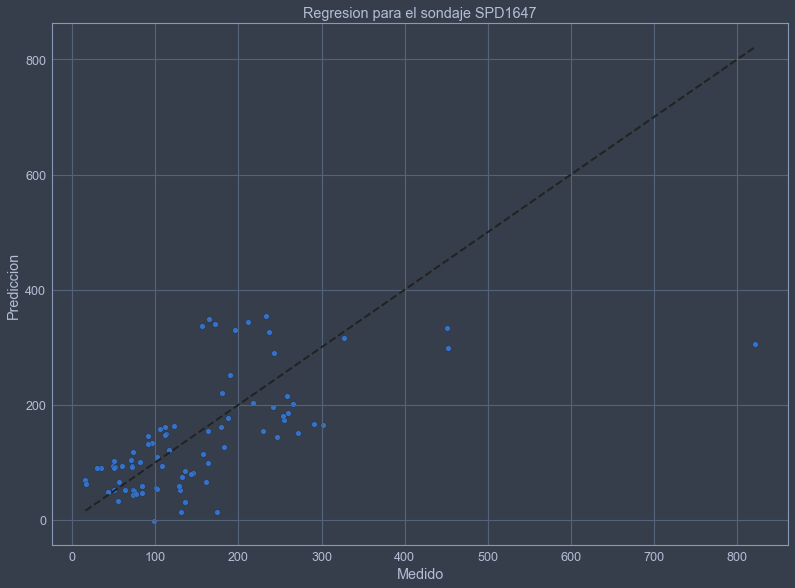


Parametros del kernel despues del entrenamiento

  sum.                    |   value  |  constraints   |  priors
  mul.Mat32.variance      |   220.0  |   +ve fixed    |        
  mul.Mat32.lengthscale   |    (3,)  |   +ve fixed    |        
  mul.Cosine.variance     |   242.0  |   +ve fixed    |        
  mul.Cosine.lengthscale  |   966.0  |   +ve fixed    |        
  Mat32.variance          |  1000.0  |  500.0,1000.0  |        
  Mat32.lengthscale       |    25.0  |   +ve fixed    |        
LengthScales de Mat52Ard
  index  |  sparse_gp.sum.mul.Mat32.lengthscale  |  constraints  |  priors
  [0]    |                        1972.00000000  |   +ve fixed   |        
  [1]    |                          71.00000000  |   +ve fixed   |        
  [2]    |                        6285.00000000  |   +ve fixed   |        


In [97]:
# matern32 ARD
mat32_ard = GPy.kern.Matern32(3,ARD=True)
mat32_ard.variance = 220
mat32_ard.lengthscale[0] = 1972
mat32_ard.lengthscale[1] = 71
mat32_ard.lengthscale[2] = 6285
mat32_ard.constrain_fixed() # se mantienen los parametros de antes

# coseno
cos = GPy.kern.Cosine(input_dim=1,active_dims=[2])
cos.lengthscale = 966
cos.variance = 242
cos.constrain_fixed() # se mantienen los parametros de antes

# matern32 en z
mat32_z = GPy.kern.Matern32(input_dim = 1, active_dims = [2])
mat32_z.lengthscale = 25
mat32_z.lengthscale.fix()
mat32_z.variance.constrain_bounded(500,1000)

ker = mat32_ard*cos + mat32_z# este kernel, con los parametros libre mejor un poquito el modelo
print(ker)
print('')
y_preds, y_medido, dicc_preds_mat32ARDCosZ_mat32Z = main_jupyter('sgpr',ker,Plotear = True)

print('')
print('Parametros del kernel despues del entrenamiento\n')
print(ker)
print('LengthScales de Mat52Ard')
print(ker.mul.Mat32.lengthscale)

# Kernel: $\cos(z) \text{Mat}32\text{ARD}(x,y,z)+ algo$

* El coseno recupera las osilaciones, pero derrepente explota (<span style="color:red">notar</span> que `distancia` = 50).
* Lo anterior pero para `distancia` = 100: suavizo aun mas donde se encontraban los datos altos.(<span style="color:red">notar</span>:Entonces,  menor cantidad de dato permite capturar la variabilidad mejor)

 C:\Users\jpdon\Anaconda3\lib\site-packages\paramz-0.8.7-py3.6.egg\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


  sum.                    |  value  |  constraints  |  priors
  mul.Mat32.variance      |  220.0  |   +ve fixed   |        
  mul.Mat32.lengthscale   |   (3,)  |   +ve fixed   |        
  mul.Cosine.variance     |  242.0  |   +ve fixed   |        
  mul.Cosine.lengthscale  |  966.0  |   +ve fixed   |        
  Cosine.variance         |    1.0  |      +ve      |        
  Cosine.lengthscale      |    1.0  |      +ve      |        

Se ajusta el modelo para id: SPD1647

Puntos a estimar:82




 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:167: RuntimeWarning:overflow encountered in true_divide
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:594: RuntimeWarning:invalid value encountered in cos
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:205: RuntimeWarning:overflow encountered in true_divide
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\core\sparse_gp.py:115: RuntimeWarning:invalid value encountered in add
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:331: RuntimeWarning:divide by zero encountered in true_divide
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\core\sparse_gp.py:118: RuntimeWarning:invalid value encountered in add
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:205: RuntimeWarning:overflow encountered in multiply


Entrenamiento para sondaje SPD1647 terminado

#############################################################



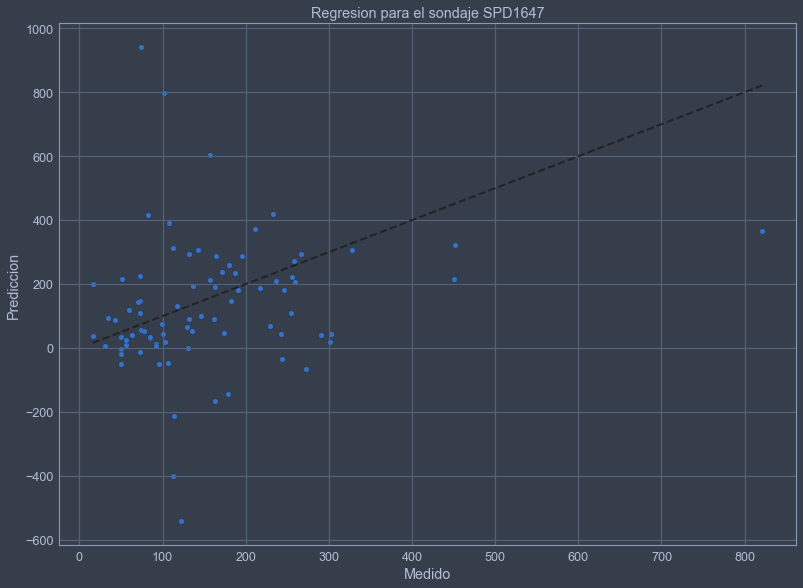


Parametros del kernel despues del entrenamiento

  sum.                    |             value  |  constraints  |  priors
  mul.Mat32.variance      |             220.0  |   +ve fixed   |        
  mul.Mat32.lengthscale   |              (3,)  |   +ve fixed   |        
  mul.Cosine.variance     |             242.0  |   +ve fixed   |        
  mul.Cosine.lengthscale  |             966.0  |   +ve fixed   |        
  Cosine.variance         |    0.997586551178  |      +ve      |        
  Cosine.lengthscale      |  0.00101696660898  |      +ve      |        
LengthScales de Mat52Ard
  index  |  sparse_gp.sum.mul.Mat32.lengthscale  |  constraints  |  priors
  [0]    |                        1972.00000000  |   +ve fixed   |        
  [1]    |                          71.00000000  |   +ve fixed   |        
  [2]    |                        6285.00000000  |   +ve fixed   |        


In [99]:
# matern32 ARD
mat32_ard = GPy.kern.Matern32(3,ARD=True)
mat32_ard.variance = 220
mat32_ard.lengthscale[0] = 1972
mat32_ard.lengthscale[1] = 71
mat32_ard.lengthscale[2] = 6285
mat32_ard.constrain_fixed()

# coseno
cos = GPy.kern.Cosine(input_dim=1,active_dims=[2])
cos.lengthscale = 966
cos.variance = 242
cos.constrain_fixed()

# algo
algo = GPy.kern.Cosine(input_dim=1,active_dims=[2])#*GPy.kern.RBF(input_dim =1, active_dims = [2])
ker = mat32_ard*cos + algo# este kernel, con los parametros libre mejor un poquito el modelo
print(ker)
print('')
y_preds, y_medido, dicc_preds_mat32ARDCosZ_algo = main_jupyter('sgpr',ker,Plotear = True)

print('')
print('Parametros del kernel despues del entrenamiento\n')
print(ker)
print('LengthScales de Mat52Ard')
print(ker.mul.Mat32.lengthscale)

# Kernel: $\text{Mat}52(x,y,z)$

  Mat52.       |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    1.0  |      +ve      |        

Se ajusta el modelo para id: SPD1647

Puntos a estimar:82




 C:\Users\jpdon\Anaconda3\lib\site-packages\paramz-0.8.7-py3.6.egg\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:519: RuntimeWarning:overflow encountered in square
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:519: RuntimeWarning:invalid value encountered in multiply
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:167: RuntimeWarning:overflow encountered in true_divide


Entrenamiento para sondaje SPD1647 terminado

#############################################################



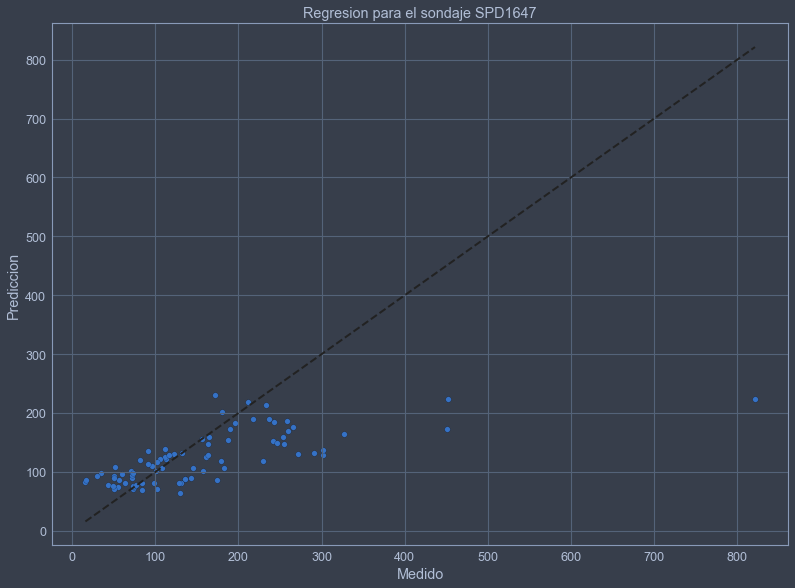


Parametros del kernel despues del entrenamiento

  Mat52.       |          value  |  constraints  |  priors
  variance     |  4055.33172708  |      +ve      |        
  lengthscale  |  110.658421142  |      +ve      |        


In [33]:
# kernel: Matern52(3)
ker = GPy.kern.Matern52(3)
print(ker)
print('')
y_preds, y_medido, dicc_preds_mat52ARD = main_jupyter('sgpr',ker,Plotear = True)
print('')
print('Parametros del kernel despues del entrenamiento\n')
print(ker)

   # Kernel: $\text{Mat}52(z)$

  Mat52.       |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    1.0  |      +ve      |        

Se ajusta el modelo para id: SPD1647

Puntos a estimar:82




 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\core\gp.py:87: UserWarning:Your kernel has a different input dimension 1 then the given X dimension 3. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel
 C:\Users\jpdon\Anaconda3\lib\site-packages\paramz-0.8.7-py3.6.egg\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:167: RuntimeWarning:overflow encountered in true_divide
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:519: RuntimeWarning:invalid value encountered in multiply
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:519: RuntimeWarning:overflow encountered in multiply
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:519: RuntimeWarning:overflow encountered in square


Entrenamiento para sondaje SPD1647 terminado

#############################################################



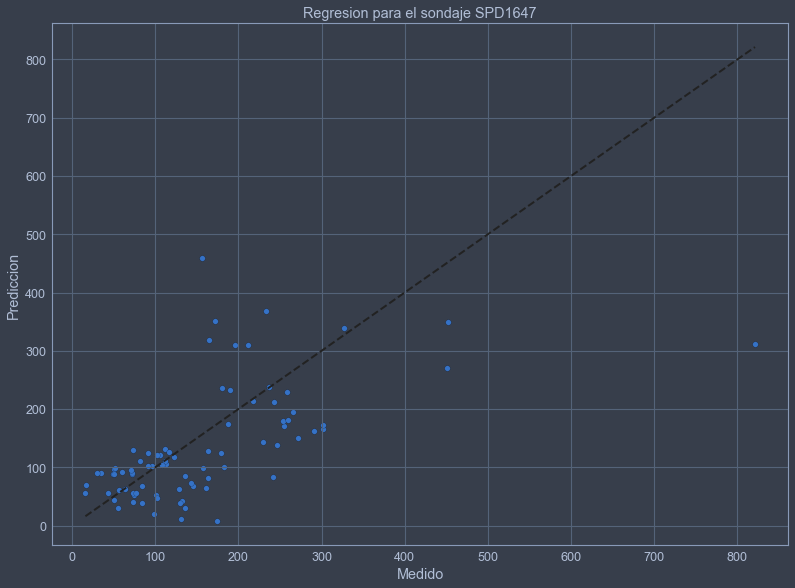


Parametros del kernel despues del entrenamiento

  Mat52.       |          value  |  constraints  |  priors
  variance     |  7892.90997192  |      +ve      |        
  lengthscale  |  9430706.30404  |      +ve      |        
LengthScales de Mat52Ard
  index  |  sparse_gp.Mat52.lengthscale  |  constraints  |  priors
  [0]    |             9430706.30404409  |      +ve      |        


In [15]:
mat52_z = GPy.kern.Matern52(input_dim=1, active_dims=[2])
ker  = mat52_z
print(ker)
print('')
_,_, dicc_preds_mat52Z = main_jupyter('sgpr',ker,Plotear = True)
print('')
print('Parametros del kernel despues del entrenamiento\n')
print(ker)
print('LengthScales de Mat52Ard')
print(ker.lengthscale)

# Kernel: $\text{Mat}52\text{ARD}(x,y,z)$

  Mat52.       |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |   (3,)  |      +ve      |        

Se ajusta el modelo para id: SPD1647

Puntos a estimar:82




 C:\Users\jpdon\Anaconda3\lib\site-packages\paramz-0.8.7-py3.6.egg\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:invalid value encountered in add
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:136: RuntimeWarning:overflow encountered in square
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:236: RuntimeWarning:invalid value encountered in true_divide
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:519: RuntimeWarning:invalid value encountered in multiply


Entrenamiento para sondaje SPD1647 terminado

#############################################################



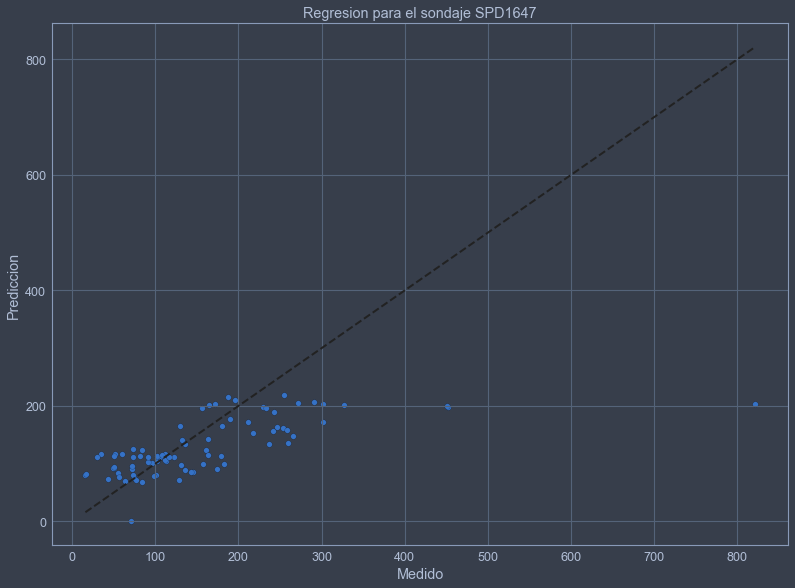


Parametros del kernel despues del entrenamiento

  Mat52.       |          value  |  constraints  |  priors
  variance     |  4645.66724207  |      +ve      |        
  lengthscale  |           (3,)  |      +ve      |        
LengthScales de Mat52Ard
  index  |  sparse_gp.Mat52.lengthscale  |  constraints  |  priors
  [0]    |                  61.16075512  |      +ve      |        
  [1]    |                 213.36990042  |      +ve      |        
  [2]    |               26212.22744395  |      +ve      |        


In [34]:
# kernel: Mattern52(ARD = True)
ker = GPy.kern.Matern52(3,ARD=True)
print(ker)
print('')
y_preds, y_medido, dicc_preds_mat52ARD = main_jupyter('sgpr',ker,Plotear = True)
print('')
print('Parametros del kernel despues del entrenamiento\n')
print(ker)
print('LengthScales de Mat52Ard')
print(ker.lengthscale)

# Kernel: $\cos(z) \text{Mat}52(x,y,z)$

  mul.                |  value  |  constraints  |  priors
  Mat52.variance      |    1.0  |      +ve      |        
  Mat52.lengthscale   |    1.0  |      +ve      |        
  Cosine.variance     |    1.0  |      +ve      |        
  Cosine.lengthscale  |   10.0  |      +ve      |        

Se ajusta el modelo para id: SPD1647

Puntos a estimar:82




 C:\Users\jpdon\Anaconda3\lib\site-packages\paramz-0.8.7-py3.6.egg\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:519: RuntimeWarning:overflow encountered in square
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:519: RuntimeWarning:invalid value encountered in multiply
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:167: RuntimeWarning:overflow encountered in true_divide


Entrenamiento para sondaje SPD1647 terminado

#############################################################



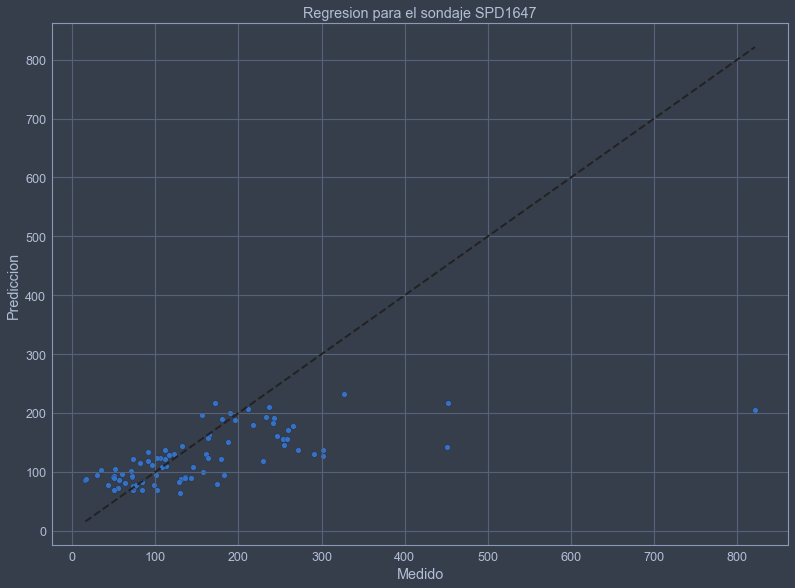


Parametros del kernel despues del entrenamiento
  mul.                |          value  |  constraints  |  priors
  Mat52.variance      |  81.5189747052  |      +ve      |        
  Mat52.lengthscale   |  110.574442506  |      +ve      |        
  Cosine.variance     |  49.6224809571  |      +ve      |        
  Cosine.lengthscale  |  10064.9246727  |      +ve      |        


In [15]:
#ker = cos(z)*mat52
mat52 = GPy.kern.Matern52(3)
cos = GPy.kern.Cosine(input_dim=1,active_dims=[2])
cos.lengthscale = 10
ker = mat52*cos # este kernel, con los parametros libre mejor un poquito el modelo
print(ker)
print('')
y_preds, y_medido, dicc_preds_mat52CosZ = main_jupyter('sgpr',ker,Plotear = True)
print('')
print('Parametros del kernel despues del entrenamiento')
print(ker)

# Kernel: $\cos(z) \text{Mat}52\text{ARD}(x,y,z)$

  mul.                |  value  |  constraints  |  priors
  Mat52.variance      |    1.0  |      +ve      |        
  Mat52.lengthscale   |   (3,)  |      +ve      |        
  Cosine.variance     |    1.0  |      +ve      |        
  Cosine.lengthscale  |   10.0  |      +ve      |        

Se ajusta el modelo para id: SPD1647

Puntos a estimar:82




 C:\Users\jpdon\Anaconda3\lib\site-packages\paramz-0.8.7-py3.6.egg\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:136: RuntimeWarning:overflow encountered in square
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:invalid value encountered in add
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:236: RuntimeWarning:invalid value encountered in true_divide


Entrenamiento para sondaje SPD1647 terminado

#############################################################



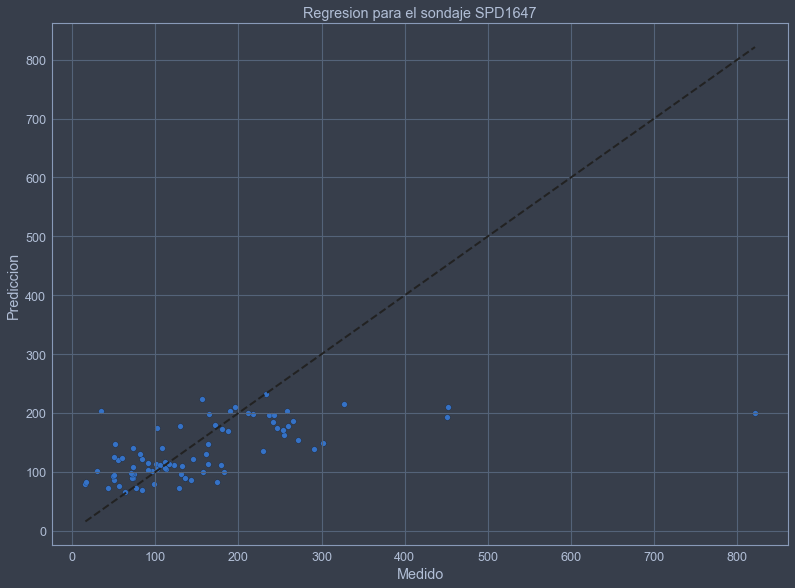


  mul.                |          value  |  constraints  |  priors
  Mat52.variance      |  640.077087982  |      +ve      |        
  Mat52.lengthscale   |           (3,)  |      +ve      |        
  Cosine.variance     |  640.077087994  |      +ve      |        
  Cosine.lengthscale  |  4264.34802774  |      +ve      |        
LengthScales de Mat52Ard
  index  |  sparse_gp.mul.Mat52.lengthscale  |  constraints  |  priors
  [0]    |                    1710.17363743  |      +ve      |        
  [1]    |                      92.12343782  |      +ve      |        
  [2]    |                    6767.63785454  |      +ve      |        


In [36]:
#ker = cos(z)*mat52ARD
mat52_ard = GPy.kern.Matern52(3,ARD=True)
cos = GPy.kern.Cosine(input_dim=1,active_dims=[2])
cos.lengthscale = 10
ker = mat52_ard*cos # este kernel, con los parametros libre mejor un poquito el modelo
print(ker)
print('')
y_preds, y_medido, dicc_preds_mat52ARDCosZ = main_jupyter('sgpr',ker,Plotear = True)
print('')
print(ker)
print('LengthScales de Mat52Ard')
print(ker.Mat52.lengthscale)

In [134]:
def estimacion_por_dhid(modelo,ker,Plotear = True):
    # En vez de estimar puntualmente, se estima
    # cada dhid con un solo conjunto de entrenamiento
    
    # se define el objeto dataFrame que almacenara las predicciones
    cols_names = ['dhid', 'midx', 'midy', 'midz', 'au_gp', 'sigma']
    df = pd.DataFrame(columns=cols_names)
    
    # diccionario que guardara las predicciones por dhid
    dicc_preds = dict() 
    
    # distancia a la que se buscan muestras (quizas es mejor tomar la minima necesaria?)
    distancia = 50
    DHIDs = get_dhids()
    #for dhid in DHIDs:
    for dhid in ['SPD1647']:
    
        # se define la lista con key dhid para guardar predicciones
        dicc_preds[dhid] = list()
        
        # se obtienen los datos de entrenamiento
        X_df,y_df = get_traningSet(dhid,distancia)
        X = X_df[['midx','midy','midz']].as_matrix()
        y = y_df[['au']].as_matrix()
        
        # se obtienen puntos donde se realiza la estimacion
        X_test = get_test_points_dhid(dhid)
        
        # se inicializa el objeto moodelo segun str modelo
        if modelo == 'sgpr':
            m = GPy.models.SparseGPRegression(X,y,ker)
            #m.inducing_inputs.constrain_fixed()
        else:
            m = GPy.models.GPRegression(X,y, ker)
        # se intenta realizar el modelo
        y_preds = np.zeros((X_test.shape[0],1))
        try:
            m.optimize(messages = True, max_f_eval = 1000)
            y_preds,_ = m.predict(X_test)
            print('se logro optimizar la funcion')
        except np.linalg.LinAlgError:
            print('La matriz definida por el kernel no es definida positiva')
            pass
        print('Entrenamiento para sondaje {} terminado'.format(dhid))
        # transformar restricciones en ndarray, por sia caso
        y_preds_ndarray = np.array(y_preds.copy())
        dicc_preds[dhid] = y_preds_ndarray
        
        # guardar valores reales de oro en los puntos test de dhid
        y_medido = get_y_dhid(dhid).reshape(y_preds_ndarray.shape)
        
        # se analizan los resultados por dhid
        fig, ax = plt.subplots()
        ax.scatter(y_medido,y_preds_ndarray , edgecolors=(0, 0, 0))
        ax.plot([y_medido.min(), y_medido.max()], [y_medido.min(), y_medido.max()], 'k--', lw=2)
        ax.set_xlabel('Medido')
        ax.set_ylabel('Prediccion')
        ax.set_title('Regresion para el sondaje %s' % dhid)
        # ax.set_title('DHID:%s, Kernel: %s' % (dhid,gp.kernel_))
        print('')
        print('#############################################################')
        print('')
        
    if Plotear:
        plt.show()
    return m,dicc_preds

# Entrenamiento por dhid

La idea en este parte es ver como se diferencia el entrenamiento hecha para cada test, respecto al entrenamiento para todo el sondaje y la posterior evalucion simultanea del modelo en los puntos de dicho sondaje.

  Mat32.       |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    1.0  |      +ve      |        

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0006   1.351016e+05   3.863120e+08 
    00s06  0013   1.430073e+04   9.283658e+04 
    00s09  0017   4.900507e+03   1.025810e+03 
    00s14  0025   1.056705e+03   1.959874e-01 
    00s17  0031   7.681270e+02   6.259642e-03 
    00s18  0035   7.547826e+02   2.541703e-04 

 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\core\gp.py:87: UserWarning:Your kernel has a different input dimension 1 then the given X dimension 3. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


    00s18  0036   7.545721e+02   7.917710e-05 
    00s24  0055   7.495097e+02   4.797205e-13 
Runtime:     00s24
Optimization status: Converged

se logro optimizar la funcion
Entrenamiento para sondaje SPD1647 terminado

#############################################################



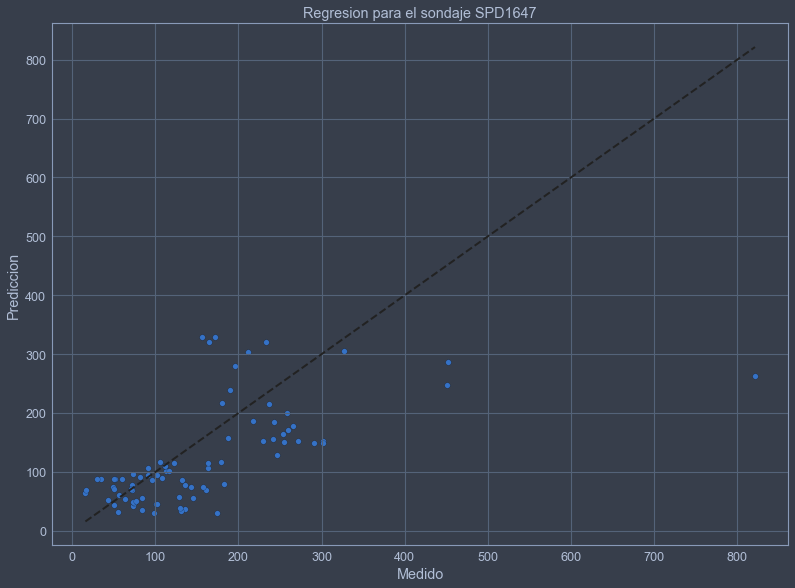


Parametros del kernel despues del entrenamiento

  Mat32.       |          value  |  constraints  |  priors
  variance     |  18949.8269352  |      +ve      |        
  lengthscale  |  88.9027910362  |      +ve      |        


In [135]:
# kernel Matern32(z)
mat32_z = GPy.kern.Matern32(input_dim=1, active_dims=[2])

ker = mat32_z# este kernel, con los parametros libre mejor un poquito el modelo

print(ker)
print('')

m,preds_mat32Z = estimacion_por_dhid('gpr',ker,Plotear = True)

print('')
print('Parametros del kernel despues del entrenamiento\n')
print(ker)

reconstraining parameters Cosine.variance
 C:\Users\jpdon\Anaconda3\lib\site-packages\paramz-0.8.7-py3.6.egg\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


  sum.                |     value  |    constraints     |  priors
  Cosine.variance     |      75.0  |  fixed 50.0,100.0  |        
  Cosine.lengthscale  |       1.0  |        +ve         |        
  Mat32.variance      |  18949.82  |     +ve fixed      |        
  Mat32.lengthscale   |      88.9  |     +ve fixed      |        

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0007   7.513690e+04   9.532683e+08 
    00s06  0009   4.512719e+04   2.688202e+08 
    00s10  0016   7.569629e+03   3.247267e+06 
    00s18  0029   5.992394e+06   2.621318e-02 
    00s34  0063   7.492121e+02   5.175402e-05 
Runtime:     00s34
Optimization status: Converged

se logro optimizar la funcion
Entrenamiento para sondaje SPD1647 terminado

#############################################################



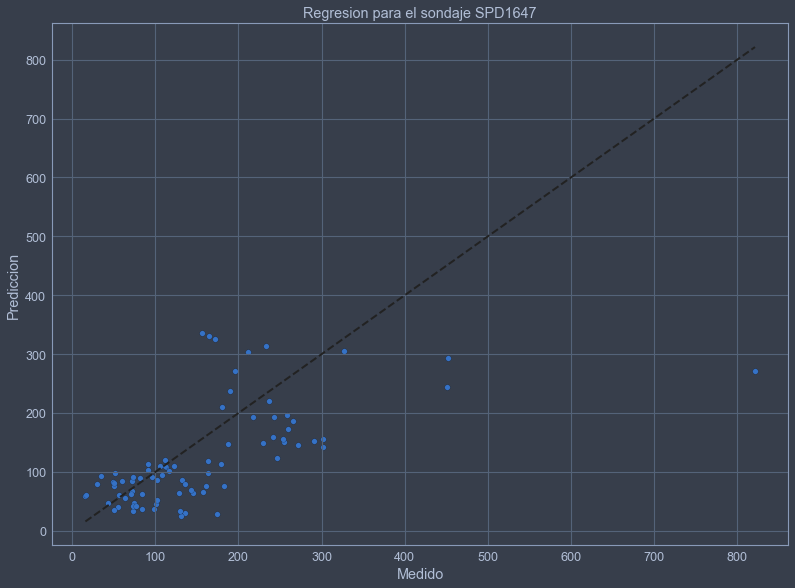


Parametros del kernel despues del entrenamiento

  sum.                |           value  |    constraints     |  priors
  Cosine.variance     |            75.0  |  fixed 50.0,100.0  |        
  Cosine.lengthscale  |  0.181638747045  |        +ve         |        
  Mat32.variance      |        18949.82  |     +ve fixed      |        
  Mat32.lengthscale   |            88.9  |     +ve fixed      |        


In [71]:
# kernel Matern32(z)+Cos(z)

# matern32(z)
mat32_z = GPy.kern.Matern32(input_dim=1, active_dims=[2])
mat32_z.variance = 18949.82
mat32_z.lengthscale = 88.90
mat32_z.constrain_fixed()

# cosine(z)
cos_z = GPy.kern.Cosine(input_dim=1, active_dims=[2])
cos_z.variance.constrain_bounded(50,100)
cos_z.variance.fix()

ker = cos_z+mat32_z# este kernel, con los parametros libre mejor un poquito el modelo

print(ker)
print('')

_,preds_CosZmat32Z = estimacion_por_dhid('gpr',ker,Plotear = True)

print('')
print('Parametros del kernel despues del entrenamiento\n')
print(ker)

reconstraining parameters Cosine.variance


  mul.                |     value  |    constraints     |  priors
  Cosine.variance     |      75.0  |  fixed 50.0,100.0  |        
  Cosine.lengthscale  |       1.0  |        +ve         |        
  Mat32.variance      |  18949.82  |     +ve fixed      |        
  Mat32.lengthscale   |      88.9  |     +ve fixed      |        

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   5.833750e+03           nan 
    00s07  0010   2.428900e+03   9.403071e+02 
    00s18  0027   1.266022e+03   1.473353e+05 

 C:\Users\jpdon\Anaconda3\lib\site-packages\paramz-0.8.7-py3.6.egg\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s31  0051   8.100970e+02   1.428061e-10 
Runtime:     00s31
Optimization status: Converged

se logro optimizar la funcion
Entrenamiento para sondaje SPD1647 terminado

#############################################################



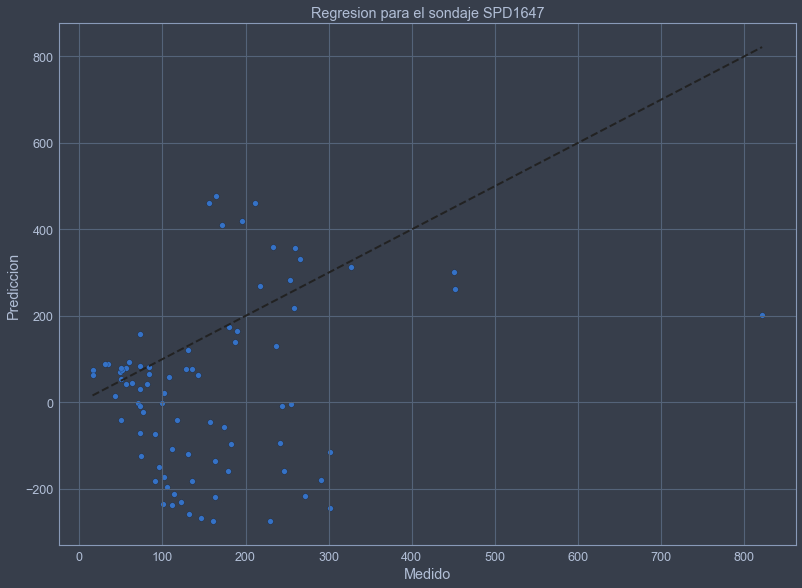


Parametros del kernel despues del entrenamiento

  mul.                |           value  |    constraints     |  priors
  Cosine.variance     |            75.0  |  fixed 50.0,100.0  |        
  Cosine.lengthscale  |  0.474724422589  |        +ve         |        
  Mat32.variance      |        18949.82  |     +ve fixed      |        
  Mat32.lengthscale   |            88.9  |     +ve fixed      |        


In [124]:
# kernel Matern32(z)*Cos(z)

# matern32(z)
mat32_z = GPy.kern.Matern32(input_dim=1, active_dims=[2])
mat32_z.variance = 18949.82
mat32_z.lengthscale = 88.90
mat32_z.constrain_fixed()

# cosine(z)
cos_z = GPy.kern.Cosine(input_dim=1, active_dims=[2])
cos_z.variance.constrain_bounded(50,100)
cos_z.variance.fix()

ker = cos_z*mat32_z# este kernel, con los parametros libre mejor un poquito el modelo

print(ker)
print('')

_,preds_CosZ_by_mat32Z = estimacion_por_dhid('gpr',ker,Plotear = True)

print('')
print('Parametros del kernel despues del entrenamiento\n')
print(ker)

reconstraining parameters Mat32.variance
reconstraining parameters Mat32.lengthscale
 C:\Users\jpdon\Anaconda3\lib\site-packages\paramz-0.8.7-py3.6.egg\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


  sum.                 |     value  |  constraints   |  priors
  Mat32.variance       |  18949.82  |   +ve fixed    |        
  Mat32.lengthscale    |      88.9  |   +ve fixed    |        
  Mat32_1.variance     |     550.0  |  100.0,1000.0  |        
  Mat32_1.lengthscale  |      55.0  |   10.0,100.0   |        

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.971796e+05           nan 
    00s03  0005   4.886133e+04   7.067680e+07 
    00s06  0009   1.222986e+04   3.669416e+05 
    00s09  0015   3.137815e+03   5.632151e+02 
    00s12  0019   1.493044e+03   6.460719e+00 
    00s23  0036   7.500946e+02   9.445929e-14 
Runtime:     00s23
Optimization status: Converged

se logro optimizar la funcion
Entrenamiento para sondaje SPD1647 terminado

#############################################################



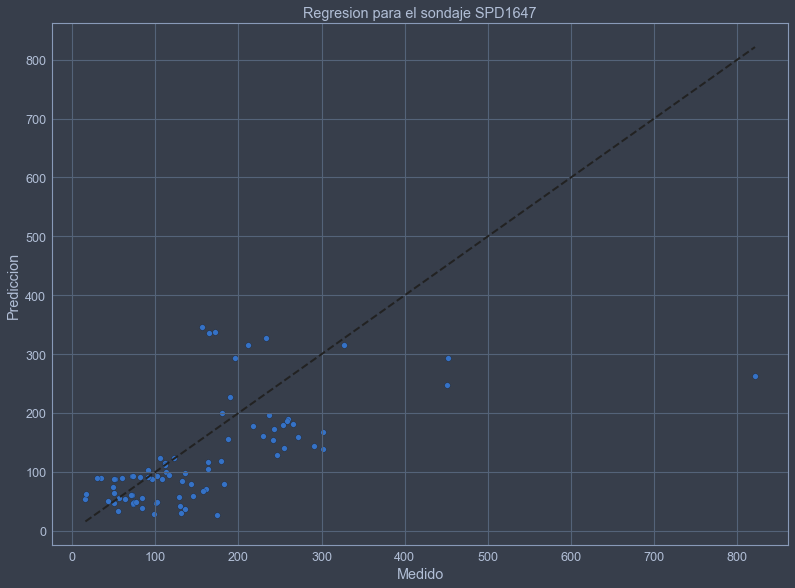


Parametros del kernel despues del entrenamiento

  sum.                 |     value  |  constraints   |  priors
  Mat32.variance       |  18949.82  |   +ve fixed    |        
  Mat32.lengthscale    |      88.9  |   +ve fixed    |        
  Mat32_1.variance     |    1000.0  |  100.0,1000.0  |        
  Mat32_1.lengthscale  |      10.0  |   10.0,100.0   |        


In [84]:
# kernel Matern32(z)+Matern32(z)

# matern32_1(z)
mat32_z_1 = GPy.kern.Matern32(input_dim=1, active_dims=[2])
mat32_z_1.variance = 18949.82
mat32_z_1.lengthscale = 88.90
mat32_z_1.constrain_fixed()

# matern32_2(z)
mat32_z_2 = GPy.kern.Matern32(input_dim=1, active_dims=[2])
mat32_z_2.variance.constrain_bounded(100,1000)
mat32_z_2.lengthscale.constrain_bounded(10,100)

ker = mat32_z_1 + mat32_z_2# este kernel, con los parametros libre mejor un poquito el modelo

print(ker)
print('')

_,preds_2mat32Z = estimacion_por_dhid('gpr',ker,Plotear = True)

print('')
print('Parametros del kernel despues del entrenamiento\n')
print(ker)

  Mat32.       |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |   (3,)  |      +ve      |        

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0008   1.363790e+05   1.204133e+08 
    00s12  0014   8.071205e+03   1.312686e+04 
    00s18  0022   1.336923e+03   1.497096e+00 
    00s26  0035   7.531233e+02   7.706527e-04 
Runtime:     00s26
Optimization status: Converged

se logro optimizar la funcion
Entrenamiento para sondaje SPD1647 terminado

#############################################################



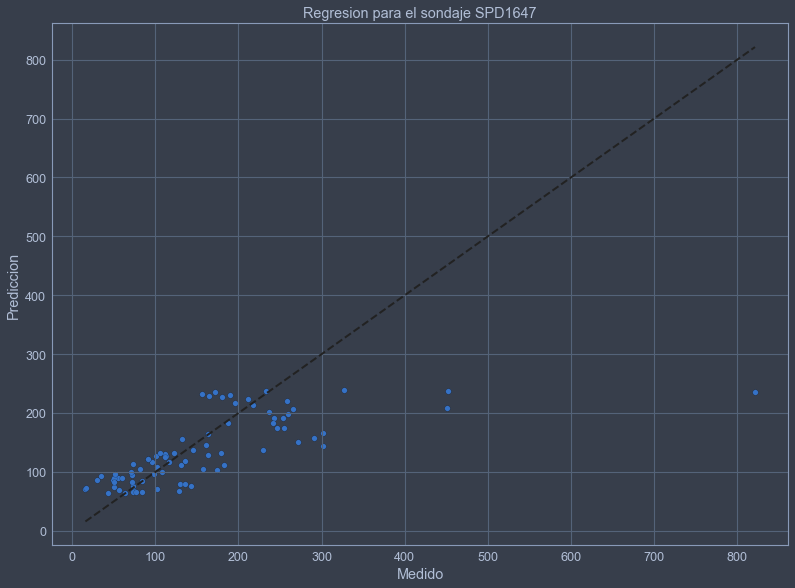


Parametros del kernel despues del entrenamiento

  Mat32.       |          value  |  constraints  |  priors
  variance     |  2641.91830592  |      +ve      |        
  lengthscale  |           (3,)  |      +ve      |        


In [125]:
# kernel Matern32ARD
mat32_ard = GPy.kern.Matern32(3,ARD=True)

ker = mat32_ard

print(ker)
print('')

_,preds_mat32ARD = estimacion_por_dhid('sgpr',ker,Plotear = True)

print('')
print('Parametros del kernel despues del entrenamiento\n')
print(ker)

reconstraining parameters Mat32.variance
reconstraining parameters Mat32.lengthscale
 C:\Users\jpdon\Anaconda3\lib\site-packages\paramz-0.8.7-py3.6.egg\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


  sum.                 |    value  |  constraints   |  priors
  Mat32.variance       |  99982.0  |   +ve fixed    |        
  Mat32.lengthscale    |     (3,)  |   +ve fixed    |        
  Mat32_1.variance     |    550.0  |  100.0,1000.0  |        
  Mat32_1.lengthscale  |     30.0  |   10.0,50.0    |        

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0002   8.211705e+04   1.285548e+09 
    00s10  0010   8.545542e+03   1.341147e+05 
    00s14  0013   4.074352e+03   4.091797e+03 
    00s18  0016   2.221265e+03   1.484075e+02 
    00s34  0035   7.401280e+02   1.499962e-11 
Runtime:     00s34
Optimization status: Converged

se logro optimizar la funcion
Entrenamiento para sondaje SPD1647 terminado

#############################################################



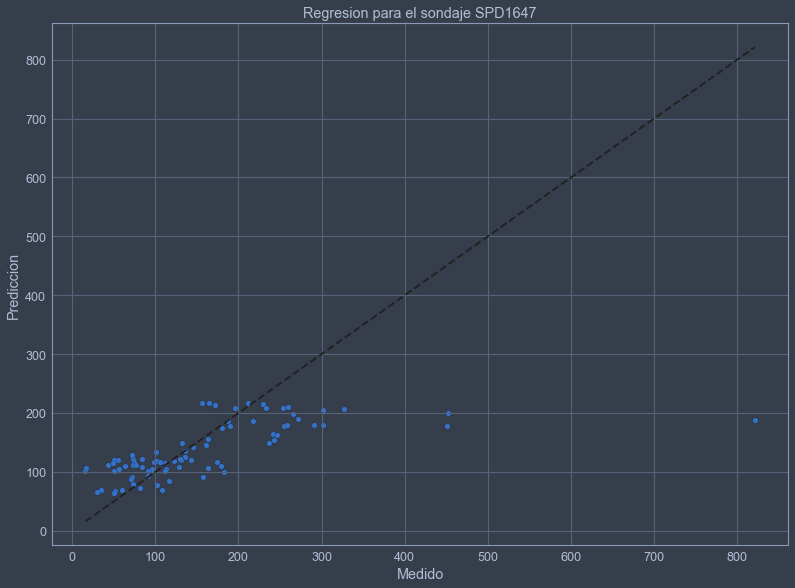


Parametros del kernel despues del entrenamiento

  Mat32_1.     |   value  |  constraints   |  priors
  variance     |  1000.0  |  100.0,1000.0  |        
  lengthscale  |    10.0  |   10.0,50.0    |        


In [126]:
# kernel Matern32ARD + Mat32(z)

# matern32ARD
mat32_ard = GPy.kern.Matern32(3,ARD=True)
mat32_ard.variance = 99982
mat32_ard.lengthscale[0] = 266.68
mat32_ard.lengthscale[1] = 643.80
mat32_ard.lengthscale[2] = 18123
mat32_ard.constrain_fixed()

# matern32(z)
mat32_z = GPy.kern.Matern32(input_dim=1, active_dims=[2])
mat32_z.variance.constrain_bounded(100,1000)
mat32_z.lengthscale.constrain_bounded(10,50)

ker = mat32_ard + mat32_z

print(ker)
print('')
_,preds_mat32ARDmat32Z = estimacion_por_dhid('sgpr',ker,Plotear = True)
print('')
print('Parametros del kernel despues del entrenamiento\n')
print(ker.Mat32_1)

  sum.                 |  value  |  constraints  |  priors
  Mat32.variance       |    1.0  |      +ve      |        
  Mat32.lengthscale    |    1.0  |      +ve      |        
  Mat32_1.variance     |    1.0  |      +ve      |        
  Mat32_1.lengthscale  |    1.0  |      +ve      |        

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0004   5.239189e+05   2.153329e+10 
    00s12  0014   1.648250e+04   1.587694e+05 
    00s17  0020   3.106830e+03   1.584618e+02 
    00s18  0021   2.439029e+03   4.553944e+01 
    00s54  0081   7.525409e+02   1.167578e-10 
Runtime:     00s54
Optimization status: Converged

se logro optimizar la funcion
Entrenamiento para sondaje SPD1647 terminado

#############################################################



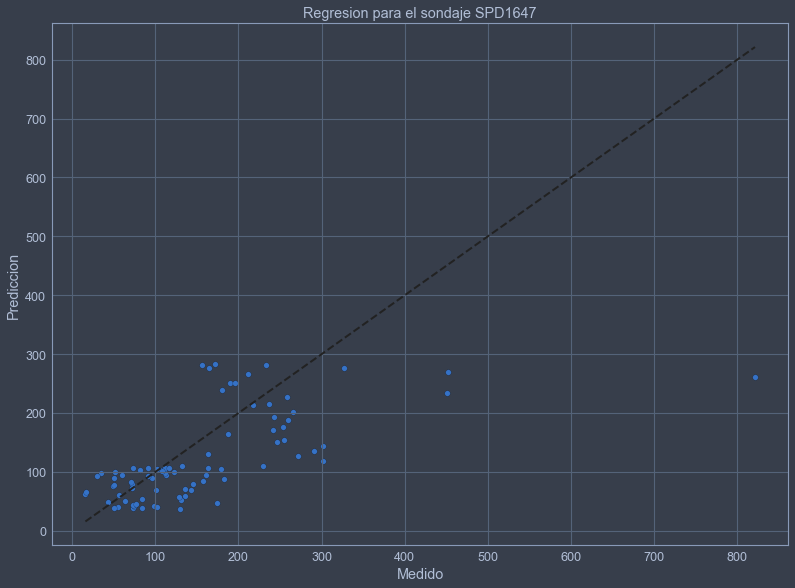

Parametros del kernel despues del entrenamiento
  sum.                 |          value  |  constraints  |  priors
  Mat32.variance       |  7921.81126244  |      +ve      |        
  Mat32.lengthscale    |  134.099361228  |      +ve      |        
  Mat32_1.variance     |  7921.81126244  |      +ve      |        
  Mat32_1.lengthscale  |  134.099361228  |      +ve      |        
  sum.                 |          value  |  constraints  |  priors
  Mat32.variance       |  7921.81126244  |   +ve fixed   |        
  Mat32.lengthscale    |  134.099361228  |   +ve fixed   |        
  Mat32_1.variance     |  7921.81126244  |   +ve fixed   |        
  Mat32_1.lengthscale  |  134.099361228  |   +ve fixed   |        
  white.variance       |            1.0  |      +ve      |        



 C:\Users\jpdon\Anaconda3\lib\site-packages\paramz-0.8.7-py3.6.egg\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0004   4.731992e+04   7.754660e+07 
    00s09  0014   3.481424e+03   9.888340e+02 
    00s10  0017   1.850033e+03   3.381203e+01 
    00s17  0025   7.990885e+02   3.311425e-03 
    00s18  0029   7.529267e+02   1.514560e-05 
    00s21  0034   7.508453e+02   9.965507e-11 
Runtime:     00s21
Optimization status: Converged

se logro optimizar la funcion
Entrenamiento para sondaje SPD1647 terminado

#############################################################



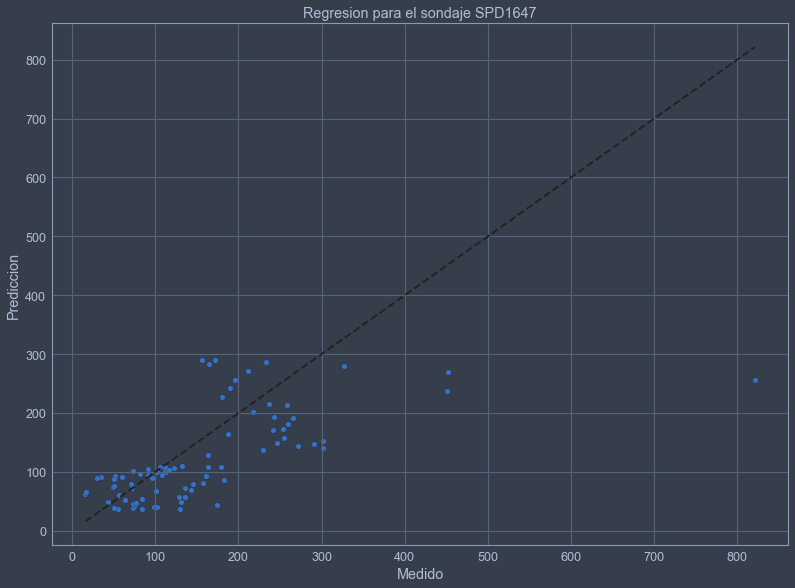

reconstraining parameters white.variance


Parametros del kernel despues del entrenamiento
  sum.                 |          value  |  constraints  |  priors
  Mat32.variance       |  7921.81126244  |   +ve fixed   |        
  Mat32.lengthscale    |  134.099361228  |   +ve fixed   |        
  Mat32_1.variance     |  7921.81126244  |   +ve fixed   |        
  Mat32_1.lengthscale  |  134.099361228  |   +ve fixed   |        
  white.variance       |   3891.2049996  |      +ve      |        
  sum.                      |          value  |  constraints   |  priors
  Mat32.variance            |  7921.81126244  |   +ve fixed    |        
  Mat32.lengthscale         |  134.099361228  |   +ve fixed    |        
  Mat32_1.variance          |  7921.81126244  |   +ve fixed    |        
  Mat32_1.lengthscale       |  134.099361228  |   +ve fixed    |        
  mul.white.variance        |          550.0  |  100.0,1000.0  |        
  mul.changepoint.variance  |            1.0  |      +ve       |        

Running L-BFGS-B (Scipy implementation

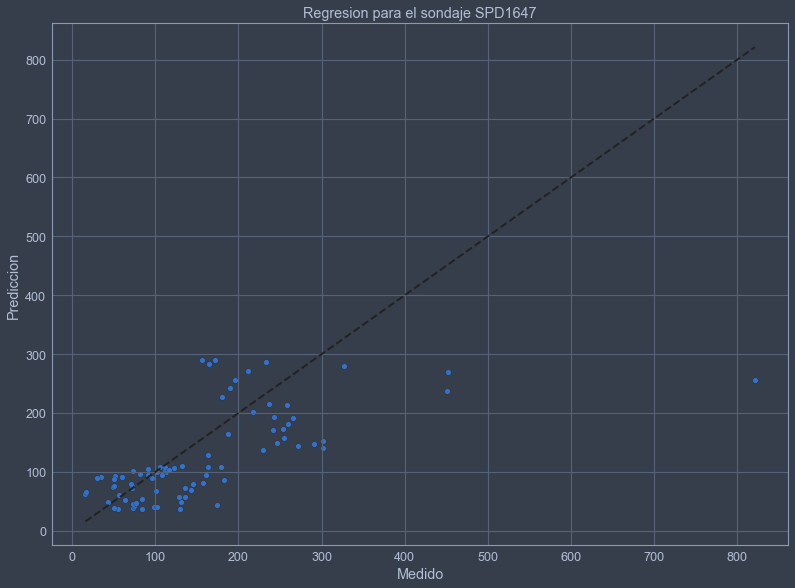

Parametros del kernel despues del entrenamiento
  sum.                      |          value  |  constraints   |  priors
  Mat32.variance            |  7921.81126244  |   +ve fixed    |        
  Mat32.lengthscale         |  134.099361228  |   +ve fixed    |        
  Mat32_1.variance          |  7921.81126244  |   +ve fixed    |        
  Mat32_1.lengthscale       |  134.099361228  |   +ve fixed    |        
  mul.white.variance        |  954.053639839  |  100.0,1000.0  |        
  mul.changepoint.variance  |  8.16427109479  |      +ve       |        


In [179]:
#suma_Matern32
ker = suma_Matern32(2,2)

print(ker)
print('')
m1,preds_sumMat32Z = estimacion_por_dhid('sgpr',ker,Plotear = True)
print('Parametros del kernel despues del entrenamiento')
print(ker)

ker1 = m1.kern
ker1.constrain_fixed()


ker3 = GPy.kern.White(input_dim=1, active_dims=[2])
ker = ker1+ker3

print(ker)
print('')
m2,preds_sumMat32ZWhite = estimacion_por_dhid('gpr',ker,Plotear = True)
print('Parametros del kernel despues del entrenamiento')
print(ker)


ker2 = GPy.kern.ChangePointBasisFuncKernel(input_dim=1,active_dims=[2],changepoint=1200)
ker3.variance.constrain_bounded(100,1000)
ker = ker1+ker3*ker2

print(ker)
print('')
m3,preds_sumMat32ZWhiteCH = estimacion_por_dhid('gpr',ker,Plotear = True)
print('Parametros del kernel despues del entrenamiento')
print(ker)

In [166]:
m2.kern.mul.changepoint

<bound method Gradcheckable.checkgrad of <GPy.kern.src.prod.Prod object at 0x0000017500EBB908>>

reconstraining parameters Cosine.lengthscale
reconstraining parameters Cosine.variance
reconstraining parameters Mat32.variance
reconstraining parameters Mat32.lengthscale
 C:\Users\jpdon\Anaconda3\lib\site-packages\paramz-0.8.7-py3.6.egg\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


  sum.                    |    value  |  constraints   |  priors
  mul.Mat32.variance      |     30.5  |   +ve fixed    |        
  mul.Mat32.lengthscale   |     (3,)  |   +ve fixed    |        
  mul.Cosine.variance     |     30.5  |   +ve fixed    |        
  mul.Cosine.lengthscale  |   142.84  |   +ve fixed    |        
  bias.variance           |  3449.96  |   +ve fixed    |        
  Cosine.variance         |    550.0  |  100.0,1000.0  |        
  Cosine.lengthscale      |     15.0  |   10.0,20.0    |        

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s10  0006   2.461654e+05   1.613413e+09 
    00s18  0010   6.601957e+04   7.961438e+06 
    01s20  0071   3.563860e+03   1.000585e-02 
    02s21  0134   3.548271e+03   4.690518e-05 
    03s54  0220   3.548131e+03   3.973190e-06 
Runtime:     03s54
Optimization status: Errorb'ABNORMAL_TERMINATION_IN_LNSRCH'

se logro optimizar la funcion
Entrenamiento para sondaje SPD1647 termina

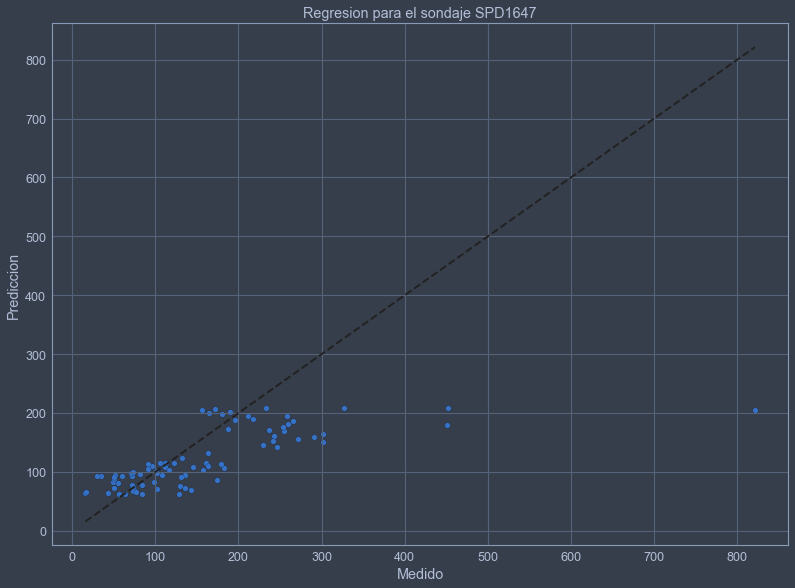


Parametros del kernel despues del entrenamiento

  sum.                    |          value  |  constraints   |  priors
  mul.Mat32.variance      |           30.5  |   +ve fixed    |        
  mul.Mat32.lengthscale   |           (3,)  |   +ve fixed    |        
  mul.Cosine.variance     |           30.5  |   +ve fixed    |        
  mul.Cosine.lengthscale  |         142.84  |   +ve fixed    |        
  bias.variance           |        3449.96  |   +ve fixed    |        
  Cosine.variance         |  100.000000134  |  100.0,1000.0  |        
  Cosine.lengthscale      |           20.0  |   10.0,20.0    |        
LengthScales de Mat52Ard
  index  |  sparse_gp.sum.mul.Mat32.lengthscale  |  constraints  |  priors
  [0]    |                         123.98000000  |   +ve fixed   |        
  [1]    |                          60.34000000  |   +ve fixed   |        
  [2]    |                         158.48000000  |   +ve fixed   |        


In [291]:
# matern32 ARD* + algo
mat32_ard = GPy.kern.Matern32(3,ARD=True)
mat32_ard.variance = 30.50
mat32_ard.lengthscale[0] = 123.98
mat32_ard.lengthscale[1] = 60.34
mat32_ard.lengthscale[2] = 158.48
mat32_ard.constrain_fixed()

# coseno
cos = GPy.kern.Cosine(input_dim=1,active_dims=[2])
cos.lengthscale = 142.84
cos.variance = 30.50
cos.constrain_fixed()

# Bias
Bias = GPy.kern.Bias(3)
Bias.variance = 3449.96
Bias.constrain_fixed()

# algo
algo = GPy.kern.Cosine(input_dim=1,active_dims=[2])#*GPy.kern.RBF(input_dim =1, active_dims = [2])
algo.lengthscale.constrain_bounded(10,20)
algo.variance.constrain_bounded(100,1000)

algo2 = GPy.kern.Matern32(input_dim=1, active_dims=[2])
algo2.variance.constrain_bounded(1000,3000)
algo2.lengthscale.constrain_bounded(10,20)

algo3 = GPy.kern.Exponential(input_dim=1, active_dims=[2])

ker = mat32_ard*cos + Bias + algo# este kernel, con los parametros libre mejor un poquito el modelo
print(ker)
print('')
_,preds_mat32ARDCosZ_algo = estimacion_por_dhid('sgpr',ker,Plotear = True)

print('')
print('Parametros del kernel despues del entrenamiento\n')
print(ker)
print('LengthScales de Mat52Ard')
print(ker.mul.Mat32.lengthscale)



In [14]:
# genero el .csv para entrenar con el kriging

X_df, y_df = get_traningSet('SPD1647',50)
y_df

,dhid,au
5714,SPD1654,92.5
5715,SPD1654,74.0
5716,SPD1654,47.0
23,N0440,151.0
24,N0440,202.0
25,N0440,205.0
26,N0440,122.0
8380,SPD1745,265.5
7363,SPD1700,239.5
7364,SPD1700,116.5


In [8]:
def get_dhids():
    df = pd.read_csv('../../GP_Data/cy17_spc_au_rl6_entry.csv')
    df_dhid = df['dhid']
    seen = set()
    DHID = []
    for item in df_dhid:
        if item not in seen:
            seen.add(item)
            DHID.append(item)
    return DHID

def plot_deriva_dhid(eje,dhid):
    eje_str = 'z'*(eje-1)*(int((eje)/2))+'x'*(1-eje)*int((2-eje)/2)+'y'*(2-eje)*(eje)
    xyz_au = get_au_xyz_by_dhid(dhid)
    n = xyz_au.shape[0]
    xx = xyz_au[:,eje]
    au = xyz_au[:,3]
    xmin = np.amin(xx)
    xmax = np.amax(xx)
    ymin = np.amin(au)
    ymax = np.amax(au)
    plt.scatter(xx,au,marker = '.',s = 200,label = 'Sondaje: '+dhid)
    #plt.plot(xx,au,linestyle = '-.',linewidth = 2,label = 'Sondaje: '+dhid)
    #plt.plot(xx,au,'bx',label = 'Sondaje: '+dhid)
    plt.title('Deriva por el eje %s para sondaje %s. (Puntos a estimar: %s)' % (eje_str,dhid,n))
    plt.xlabel('mid'+eje_str)
    plt.ylabel('au')
    plt.legend()
    plt.ylim((0,ymax))
    plt.xlim((xmin,xmax))
    plt.grid(True)
    return

def plot_estimacion(dicc,dhid,eje,etiqueta):
    eje_str = 'z'*(eje-1)*(int((eje)/2))+'x'*(1-eje)*int((2-eje)/2)+'y'*(2-eje)*(eje)
    xyz_au = get_au_xyz_by_dhid(dhid)
    xx = xyz_au[:,eje]
    au = dicc[dhid]
    au_dhid = xyz_au[:,3]
    #plt.scatter(xx,au,marker = 'x',s = 50,label = 'Kernel: '+etiqueta)
    plt.plot(xx,au, marker = '+',label = 'Kernel: '+etiqueta)
    plt.legend()
    xmin = np.amin(xx)
    xmax = np.amax(xx)
    ymin = np.amin(au_dhid)
    ymax = np.amax(au_dhid)
    plt.ylim((0,ymax))
    plt.xlim((xmin,xmax))
    plt.grid(True)
    return

def plot_trainingSet(dhid,eje,distancia, unico = False,lower_bound = 0):
    # se obtienen min y max para
    xyz_au = get_au_xyz_by_dhid(dhid)
    xx = xyz_au[:,eje]
    au = xyz_au[:,3]
    xmin = np.amin(xx)
    xmax = np.amax(xx)
    ymin = np.amin(au)
    ymax = np.amax(au)
    
    X_df,y = get_traningSet(dhid,distancia)
    n = X_df.shape[0]
    trainin_dhid = X_df['dhid']
    dhids = list(set(trainin_dhid))
    eje_str = 'z'*(eje-1)*(int((eje)/2))+'x'*(1-eje)*int((2-eje)/2)+'y'*(2-eje)*(eje)
    if not unico:
        
        for current_dhid in dhids:
            zz = X_df.loc[X_df['dhid']==current_dhid][['mid'+eje_str]].as_matrix().astype(np.int)
            au_zz = y.loc[X_df['dhid']==current_dhid][['au']].as_matrix()
            plt.scatter(zz,au_zz,marker = 'x',label = current_dhid)
        plt.xlim(5, 0)
        plt.xlabel('mid'+eje_str)
        plt.ylabel('au')
        plt.title('Puntos de entrenamiento para sondaje %s. (Puntos: %s)' % (dhid,n))
        plt.legend()
        plt.ylim((0,ymax))
        plt.xlim((xmin,xmax))
        plt.grid(True)
    else:
        plt.plot(X_df['mid'+eje_str].as_matrix(),
                 y['au'].as_matrix(),'o',label = 'Pts Entrenamiento')
        plt.xlabel('mid'+eje_str)
        plt.ylabel('au')
        plt.title('Pts. de entrenamiento y estimaciones.')
        plt.legend()
        plt.ylim((0,ymax))
        plt.xlim((xmin,xmax))
        plt.grid(True)
    return

def get_test_points_dhid(dhid):
    return train_data.loc[train_data['dhid'] == dhid][['midx', 'midy', 'midz']].as_matrix()

def get_y_dhid(dhid):
    return train_data.loc[train_data['dhid'] == dhid][['au']].as_matrix()

def get_traningSet(dhid,distancia):
    # retorna X dataFrame con los puntos de
    # entrenamiento para todo el sondaje dhid
    dhid_bool = train_data['dhid'] != dhid
    train_data_dhid = train_data[dhid_bool]
    X_train_dhid = train_data_dhid[['dhid','midx','midy','midz']]
    X_train = train_data_dhid[['midx','midy','midz']].as_matrix()
    y = train_data_dhid[['dhid','au']]
    
    test_points = get_test_points_dhid(dhid)
    test_tree = spatial.cKDTree(test_points)
    train_tree = spatial.cKDTree(X_train)
    
    idx_rep = test_tree.query_ball_tree(train_tree,distancia)
    idx_sin_rep = list(set([indice for lista in idx_rep for indice in lista]))
    
    return X_train_dhid.iloc[idx_sin_rep,:], y.iloc[idx_sin_rep,:]

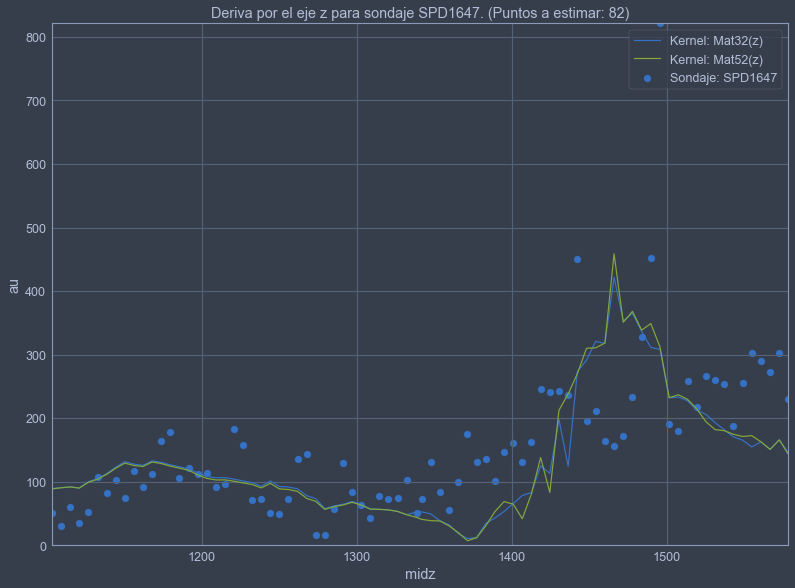

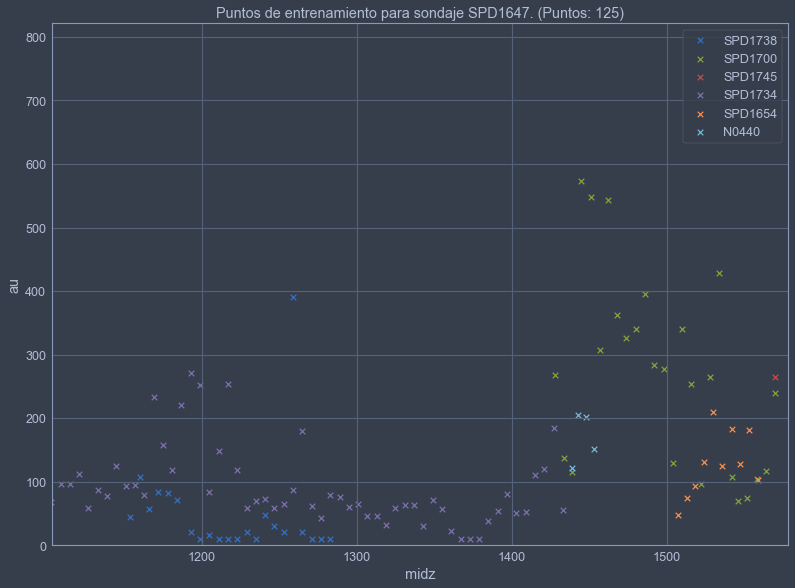

In [18]:
# analisis de train_data = pd.read_csv('../../GP_Data/cy17_spc_au_rl6_entry.csv') au por cada dimension, para diferentes dhid
dhid_1 = 'SPD1643'
dhid_2 = 'SPD1644'
dhid_3 = 'SPD1647'
dhid_4 = 'SPD1645' 
distancia = 50
dhid = dhid_3
eje = 2

# se grafica el sondaje a estimar vs eje
plt.figure()
plot_deriva_dhid(eje,dhid)

# se grafica la estimacion para Mat32 y variaciones
#plot_estimacion(dicc_preds_mat32,dhid,eje,'Matt32(3)')
plot_estimacion(dicc_preds_mat32Z,dhid,eje,'Mat32(z)')
plot_estimacion(dicc_preds_mat52Z,dhid,eje,'Mat52(z)')
#plot_estimacion(preds_mat32Z,dhid,eje,'Matt32(z)_dhid')
#plot_estimacion(preds_mat32ARD,dhid,eje,'Matt32ARD_dhid')
#plot_estimacion(preds_mat32ARDmat32Z,dhid,eje,'Matt32ARD+mat32Z_dhid')
#plot_estimacion(preds_sumMat32Z,dhid,eje,'SumMat32Z_dhid')
#plot_estimacion(preds_sumMat32ZWhite,dhid,eje,'SumMat32ZWhiet_dhid')
#plot_estimacion(preds_sumMat32ZWhiteCH,dhid,eje,'SumMat32ZWhiteCH_dhid')


#plot_estimacion(preds_CosZmat32Z,dhid,eje,'Cos(z)+Matt32(z)_dhid')
#plot_estimacion(preds_CosZ_by_mat32Z,dhid,eje,'Cos(z)*Mat32(z)_dhid')
#plot_estimacion(preds_2mat32Z,dhid,eje,'Mat32(z)+ Mat32(z)')
#plot_estimacion(dicc_preds_mat32ARD,dhid,eje,'Mat32ARD(3)')
#plot_estimacion(dicc_preds_mat32ARDmat32Z,dhid,eje,'Mat32ARD(3)*Mat32(z)')
#plot_estimacion(dicc_preds_mat32CosZ,dhid,eje,'Matt32(3)*Cos(z)')
#plot_estimacion(dicc_preds_mat32ARDCosZ,dhid,eje,'Mat32ARD(3)*Cos(z)')
#plot_estimacion(dicc_preds_mat32ARDCosZ_algo,dhid,eje,'Mat32ARD(3)*Cos(z)+algo')
#plot_estimacion(dicc_preds_mat32ARDCosZ_mat32Z,dhid,eje,'Mat32ARD(3)*Cos(z)+Mat32(z)')

#plot_estimacion(dicc_preds_mat52,dhid,eje,'Matt52(3)')
#plot_estimacion(dicc_preds_mat52ARD,dhid,eje,'Matt52(3,ARD)')
#plot_estimacion(dicc_preds_mat32ARDCosZ,dhid,eje,'Mat32ARD(3)*Cos(z)')
#plot_estimacion(preds_mat32ARDCosZ,dhid,eje,'Mat32ARD(3)*Cos(z)(dhid)')
#plot_estimacion(preds_mat32ARDCosZ_algo,dhid,eje,'Matt52(3)*Cos(z)+algo(dhid)')
#plot_estimacion(dicc_preds_mat52ARDCosZ,dhid,eje,'Matt52ARD(3)*Cos(z)')



#plot_estimacion(dicc_preds_matt32RBF,dhid,eje,'Matt32(3)+RBF(3)')
#plot_estimacion(dicc_preds_ratQuad,dhid,eje,'RatQuad(3)')
#plot_estimacion(dicc_preds_ratQuadRBF,dhid,eje,'RatQuad(3)*RBF(3)')
#plot_estimacion(dicc_preds_Cos,dhid,eje,'C1(3)*cos1(z)+C2(3)cos2(z)')


# obtenemos los test points
test_points = get_test_points_dhid(dhid)

# se obtiene data frame con los puntos de entrenamiento
X_df,y = get_traningSet(dhid,distancia)
trainin_dhid = X_df['dhid']
dhids = list(set(trainin_dhid))

# se grafican los puntos de entrenamiento
# por eje
#plt.figure()
#plot_trainingSet(dhid,eje,distancia)

# se grafican las estimaciones junto con los puntos
# de entrenamiento, sin separar estos ultimos por
# el sondaje del que provienen
plt.figure()
#plt.scatter(X_df['midz'].as_matrix(),y['au'].as_matrix(),label = 'Pts Entrenamiento')
plot_trainingSet(dhid,eje,distancia)
#plot_estimacion(dicc_preds_matt52,dhid,eje,'Matt52(3)')
#plot_estimacion(dicc_preds_matt32ARD,dhid,eje,'Matt32(3)')
#plot_estimacion(dicc_preds_matt32Cos,dhid,eje,'Matt32(3)+Cos(z)')
#plot_estimacion(dicc_preds_matt32,dhid,eje,'Matt32(3,ARD)')
#plot_estimacion(dicc_preds_matt32RBF,dhid,eje,'Matt32(3)+RBF(3)')
#plot_estimacion(dicc_preds_ratQuad,dhid,eje,'RatQuad(3)')
#plot_estimacion(dicc_preds_ratQuadRBF,dhid,eje,'RatQuad(3)*RBF(3)')
#plot_estimacion(dicc_preds_Cos,dhid,eje,'C1(3)*cos1(z)+C2(3)cos2(z)')
plt.show()

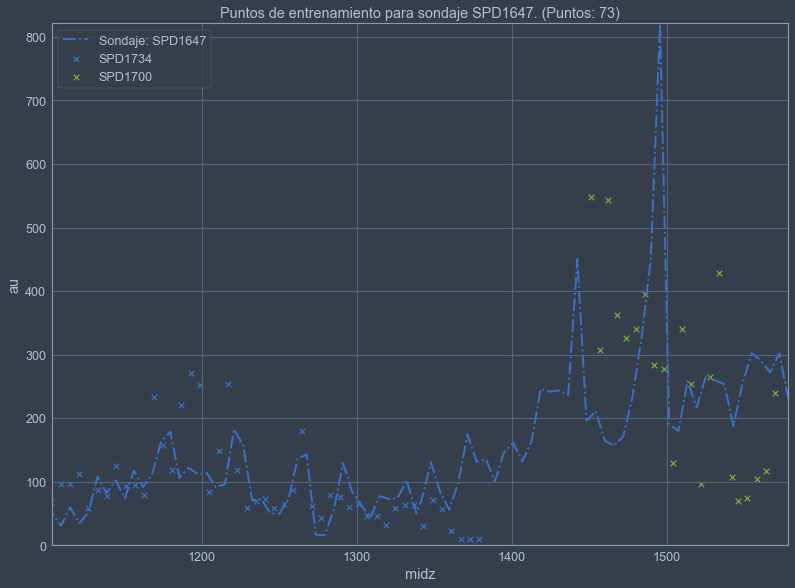

In [172]:
dhid_1 = 'SPD1643'
dhid_2 = 'SPD1644'
dhid_3 = 'SPD1647'
dhid_4 = 'SPD1645' 
distancia = 40
dhid = dhid_3
eje = 2
X_df,y = get_traningSet(dhid,distancia)
trainin_dhid = X_df['dhid']
dhids = list(set(trainin_dhid))
plot_deriva_dhid(eje,dhid)
plot_trainingSet(dhid,eje,distancia)
plt.show()

In [18]:
k1 = gpflow.kernels.RBF(input_dim=1,active_dims=[0])
k2 = gpflow.kernels.RBF(input_dim=1,active_dims=[1])
k3 = gpflow.kernels.RBF(input_dim=1,active_dims=[2])
kernel = k1+k2+k3
print(gpflow.kernels.make_kernel_names([k1,k2,k3]))

['rbf_1', 'rbf_2', 'rbf_3']


In [ ]:
X = np.linspace(0, 1, 100).reshape((100, 1))
y = np.random.normal(size=(100,1))
k = gpflow.kernels.Matern32(1, variance=1, lengthscales=1.2)
l = gpflow.likelihoods.StudentT()
m = gpflow.gpmc.GPMC(X,y,kern=k,likelihood=l)
m.kern.variance.prior = gpflow.priors.Gamma(1, 1)
m.kern.lengthscales.prior = gpflow.priors.Gamma(1, 1)

trace = m.sample(1000, verbose=True, epsilon=0.03, Lmax=15)

parameter_samples = m.get_samples_df(trace)

for col in parameter_samples.columns.sort_values()[1:]:
    parameter_samples[col].hist(label=col.split('.')[-1], alpha=0.4, bins=15)
plt.show()